In [1]:
import gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# another cell
import matplotlib.pyplot as plt
%matplotlib inline

# Values to test later on

$alpha$: 0.1 - 0.3

$\gamma$: 0.8 - 1.0

In [4]:
max_episodes = 5000
max_steps = 200
test_episodes = 1000
alpha = 0.1
gamma = 0.95
epsilon = 1.0
decay_rate = 0.01

In [5]:
class RandomAgent:

    def __init__(self, max_episodes, max_steps, test_episodes):
        self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
        self.max_episodes = max_episodes
        self.test_episodes= test_episodes
        self.steps = max_steps
        self.reward_arr = np.empty(max_episodes)
        self.counts_solved = np.zeros(max_episodes)
        
    def run(self):
        print("Running...")
        for episode in range(self.max_episodes):
            state = self.env.reset()
            done = False
            eps_reward = 0
            for step in range(self.steps):
                action = self.env.action_space.sample()
                new_state, reward, done, info, _ = self.env.step(action)
                eps_reward += reward
                state = new_state
                if done == True: 
                    self.counts_solved[episode] += 1
                    self.reward_arr[episode] = eps_reward
                    eps_reward = 0
                    break
            self.reward_arr[episode] = eps_reward
            eps_reward = 0
        print("Done!")
        self.plot_rewards()
        self.info_rewards()
        
        
    def plot_rewards(self):
        plt.figure(figsize=(15,8))
        plt.title("Total Reward per episodes for random algorithm")
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.ylim(-400, 20)
        plt.grid()
        plt.plot(self.reward_arr, label = 'Random Agent', color = "red")
        plt.legend()
        plt.show()  
        
        
    def info_rewards(self):
        print("Number of times passenger was dropped off: {}".format(sum(self.counts_solved)))
        print("Max reward: {}".format(max(self.reward_arr)))
        print("Min reward: {}".format(min(self.reward_arr)))
        print("Avg reward: {}".format(sum(self.reward_arr)/self.max_episodes))
        
    def exportCSV(self,name):
        DF = pd.DataFrame(self.reward_arr)
        DF.to_csv(name + ".csv",index=False)


Running...
Done!


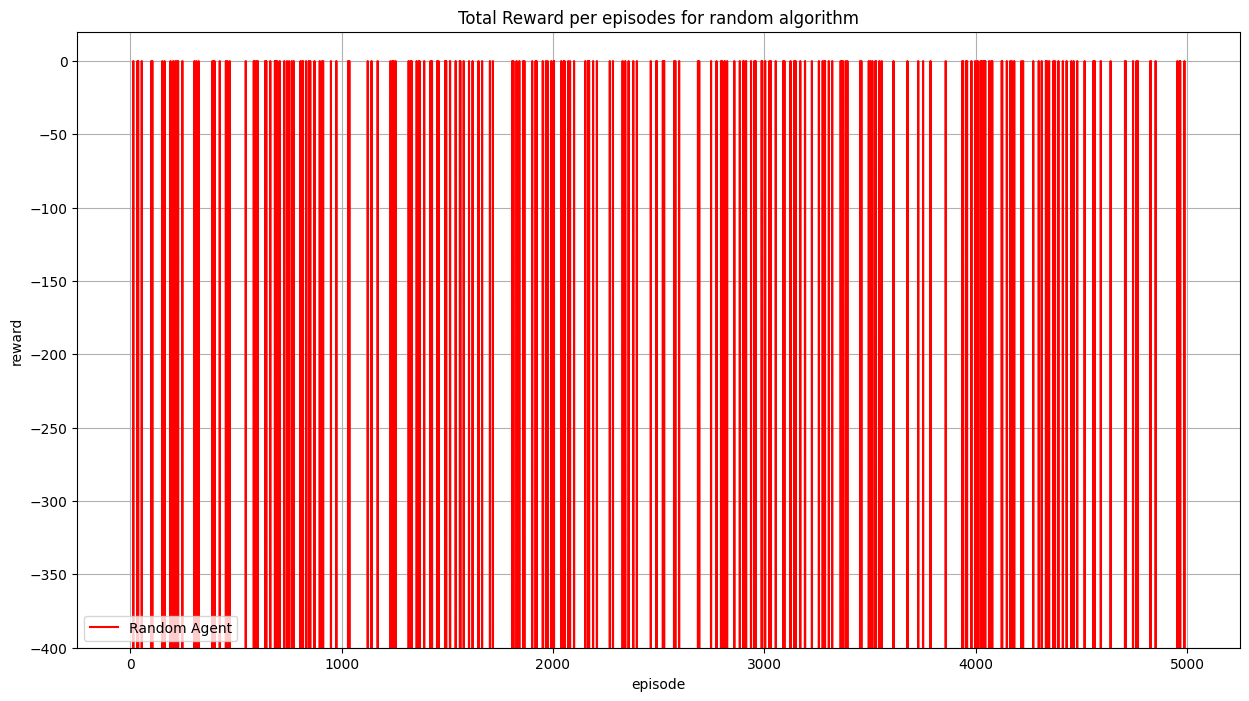

Number of times passenger was dropped off: 260.0
Max reward: 0.0
Min reward: -1001.0
Avg reward: -745.4184


In [6]:
randAgent = RandomAgent(max_episodes, max_steps, test_episodes)
randAgent.run()
randAgent.exportCSV("random_agent")

In [7]:
class SarsaAgent:
    def __init__(self, max_episodes, max_steps, test_episodes, alpha, gamma, epsilon, decay_rate, optimistic):
        self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
        self.max_episodes = max_episodes
        self.steps = max_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.reward_list= np.empty(max_episodes)
        self.counts_solved = np.zeros(max_episodes)
        self.first_solved = 0
        self.optimistic = optimistic
        
        if optimistic:
            self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        else:
            self.Q = np.ones((self.env.observation_space.n,self.env.action_space.n))
        
        
    def chooseAction(self,state):
        action = 0
        if np.random.uniform(0,1) <self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.Q[state,:])
        return action
    
    def updateQ(self, state, action, state1, action1, reward):
        currentQ = self.Q[state,action]
        self.Q[state,action] = currentQ + float(self.alpha *( reward + 
                                                             (self.gamma *self.Q[state1,action1]) - currentQ))
        
    def run(self):
        print("Training...")
        for eps in range(self.max_episodes):
            state = self.env.reset()
            action1 = self.chooseAction(state[0])
            eps_reward = 0
            for step in range(self.steps):
                #take action 
                new_state, reward, done, info, _ = self.env.step(action1)
                
                #get next action
                action2 = self.chooseAction(new_state)
                        
                #Update Q table with next action
                if type(state) == tuple:
                    self.updateQ(state[0],action1, new_state , action2, reward)
                    
                else: 
                    self.updateQ(state,action1,new_state, action2, reward)
                
                #keep track of reward
                eps_reward+=reward
                
                #overwrite state and action value
                state = new_state
                action1 = action2
                
                if done:
                    self.counts_solved[eps] += 1
                    break
            self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-self.decay_rate*eps) 
            self.reward_list[eps]= eps_reward
#             print(f"ep : {eps} , reward : {eps_reward}")
            eps_reward = 0
        print("Learning done!")
        self.plot_rewards()
        self.info_rewards()
            
    def plot_rewards(self):
        plt.figure(figsize=(15,8))
        plt.title("Total Reward per episodes for SARSA")
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.ylim(-400, 20)
        plt.grid()
        if self.optimistic:
            plt.title("Total Reward per episodes for Optimistic SARSA")

            plt.plot(self.reward_list, label = "Optimistic SARSA Agent" , color = "blue")
        else:
            plt.plot(self.reward_list, label = "SARSA Agent" , color = "red")
        plt.legend()
        plt.show()  
        
        
    def info_rewards(self):
        print("Number of times passenger was dropped off: {}".format(sum(self.counts_solved)))
        print("Max reward: {}".format(max(self.reward_list)))
        print("Min reward: {}".format(min(self.reward_list)))
        print("Avg reward: {}".format(sum(self.reward_list)/self.max_episodes))    
    
    def export_csv(self,name):
        df = pd.DataFrame(self.Q)
        df.to_csv(name+".csv",index = False)


   

In [8]:
class Q_Agent:
    def __init__(self, max_episodes, max_steps, test_episodes, alpha, gamma, epsilon, decay_rate, optimistic):
        self.env = gym.make("Taxi-v3", render_mode = "rgb_array")
        self.max_episodes = max_episodes
        self.test_episodes= test_episodes
        self.steps = max_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.reward_arr = np.empty(max_episodes)
        self.decay_rate = decay_rate
        self.counts_solved = np.zeros(max_episodes)
        self.optimistic = optimistic 
        
        if optimistic:
            self.qtable = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        else:
            self.qtable = np.ones((self.env.observation_space.n,self.env.action_space.n))
                    
                 
                 
    
    def run(self):
        print("Training....")
        for episode in range(self.max_episodes):
            state = self.env.reset()
            done = False
            eps_reward = 0
            
            for step in range(self.steps):
                exp_exp_tradeoff = random.uniform(0,1)
                if exp_exp_tradeoff > self.epsilon:
                    if type(state) == tuple:
                        action = np.argmax(self.qtable[state[0],:])
                    else:
                        action = np.argmax(self.qtable[state,:])
                
                else:
                    action = self.env.action_space.sample()
                
                new_state, reward, done, info, _ = self.env.step(action)
                eps_reward += reward
                if type(state) == tuple:
                    self.qtable[state[0], action] = self.qtable[state[0], action] + self.alpha * (reward + self.gamma * 
                                            np.max(self.qtable[new_state, :]) - self.qtable[state[0], action])
                else:
                    self.qtable[state, action] = self.qtable[state, action] + self.alpha * (reward + self.gamma * 
                                            np.max(self.qtable[new_state, :]) - self.qtable[state, action])
                    
                state = new_state

                if done == True: 
                    self.counts_solved[episode] += 1
                    self.reward_arr[episode] = eps_reward
                    eps_reward = 0
                    break
                self.reward_arr[episode] = eps_reward
            eps_reward = 0
        
        # Reduce epsilon (because we need less and less exploration)
            self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-self.decay_rate*episode) 
            
        print("Learning done!")
        self.plot_rewards()
        self.info_rewards()
        
    
            
        
        
    def plot_rewards(self):
        plt.figure(figsize=(15,8))
        plt.title(f"Total Reward per episodes for Q learning")
        plt.xlabel("episode")
        plt.ylabel("reward")
        plt.ylim(-400, 20)
        plt.grid()
        if self.optimistic:
            plt.plot(self.reward_arr, label = "Optimistic Q-learning Agent" , color = "green")
            plt.title(f"Total Reward per episodes for Optimistic Q learning")

        else:
            plt.plot(self.reward_arr, label = "Q-learning Agent" , color = "purple")
        plt.legend()
        plt.show()     
        
    def info_rewards(self):
        print("Number of times passenger was dropped off: {}".format(sum(self.counts_solved)))
        print("Max reward: {}".format(max(self.reward_arr)))
        print("Min reward: {}".format(min(self.reward_arr)))
        print("Avg reward: {}".format(sum(self.reward_arr)/self.max_episodes))
    def export_csv(self,name):
        DF = pd.DataFrame(self.reward_arr)
        DF.to_csv(name + ".csv")

    

### varying values of alpha and gamma for optimistic Sarsa agent

alpha = 0.1
...... running with alpha = 0.1 and gamma = 1 ......
Training...
Learning done!


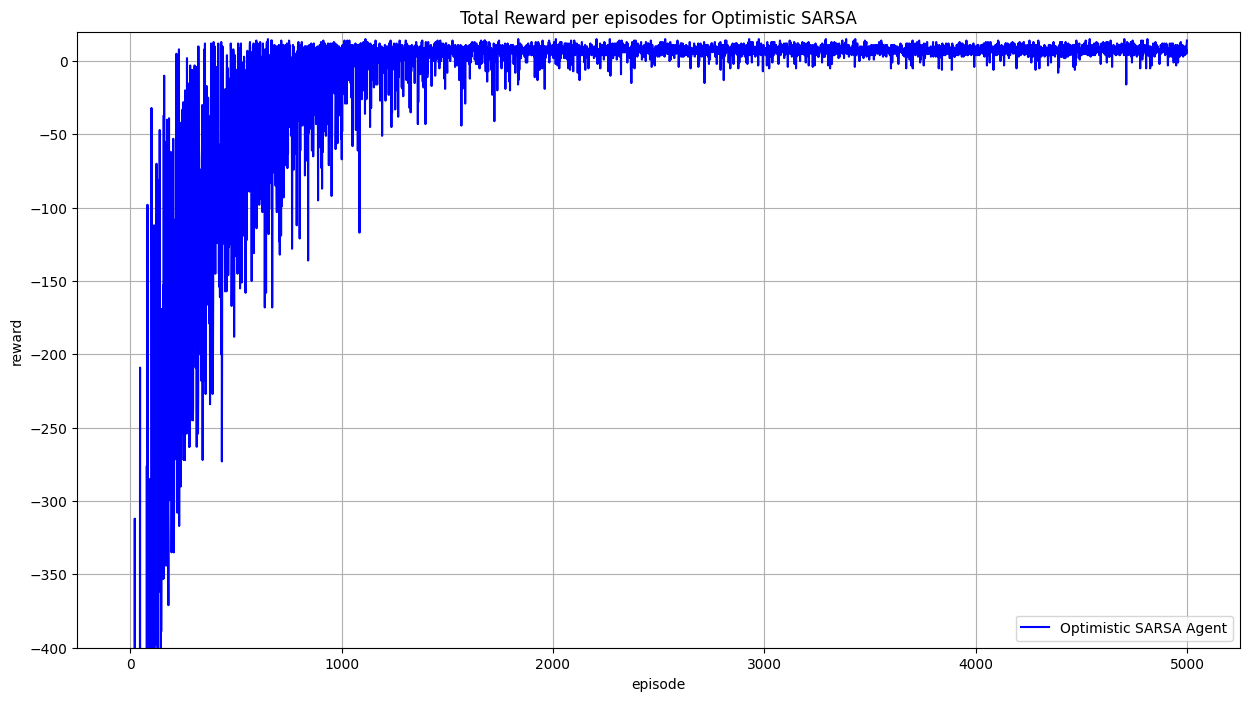

Number of times passenger was dropped off: 4811.0
Max reward: 15.0
Min reward: -911.0
Avg reward: -21.3648
...... running with alpha = 0.1 and gamma = 0.9 ......
Training...
Learning done!


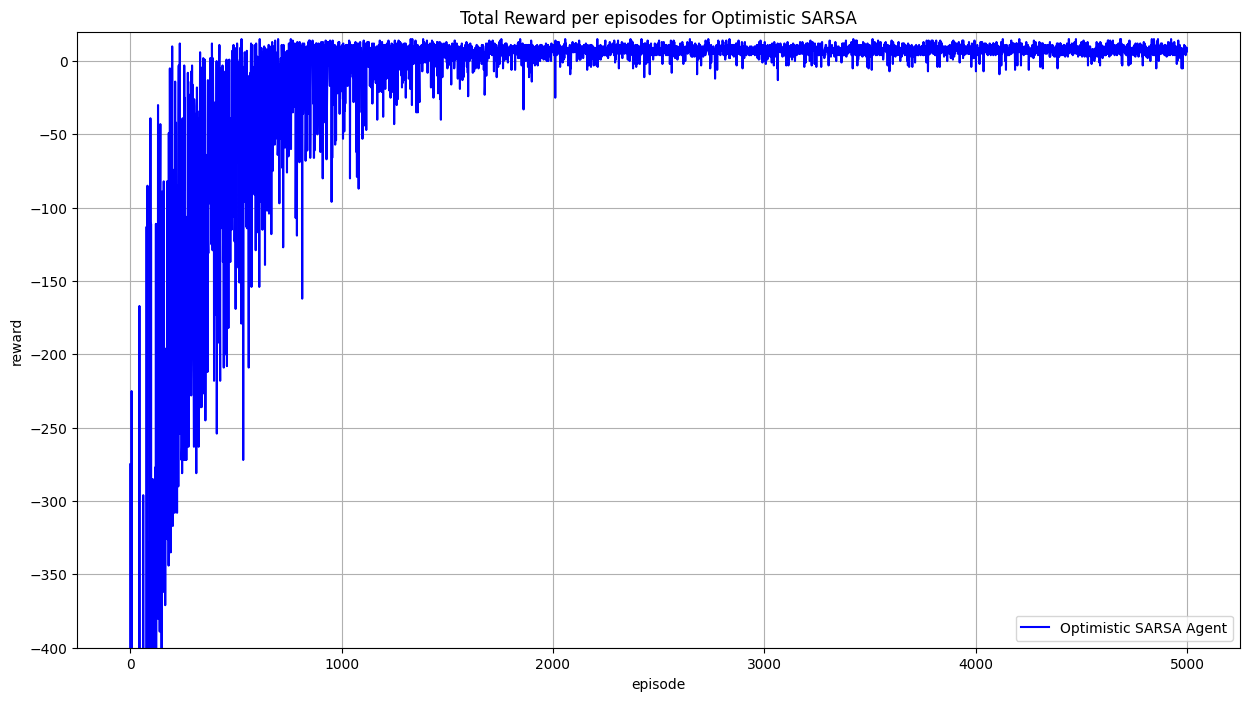

Number of times passenger was dropped off: 4804.0
Max reward: 15.0
Min reward: -884.0
Avg reward: -20.8394
...... running with alpha = 0.1 and gamma = 0.8 ......
Training...
Learning done!


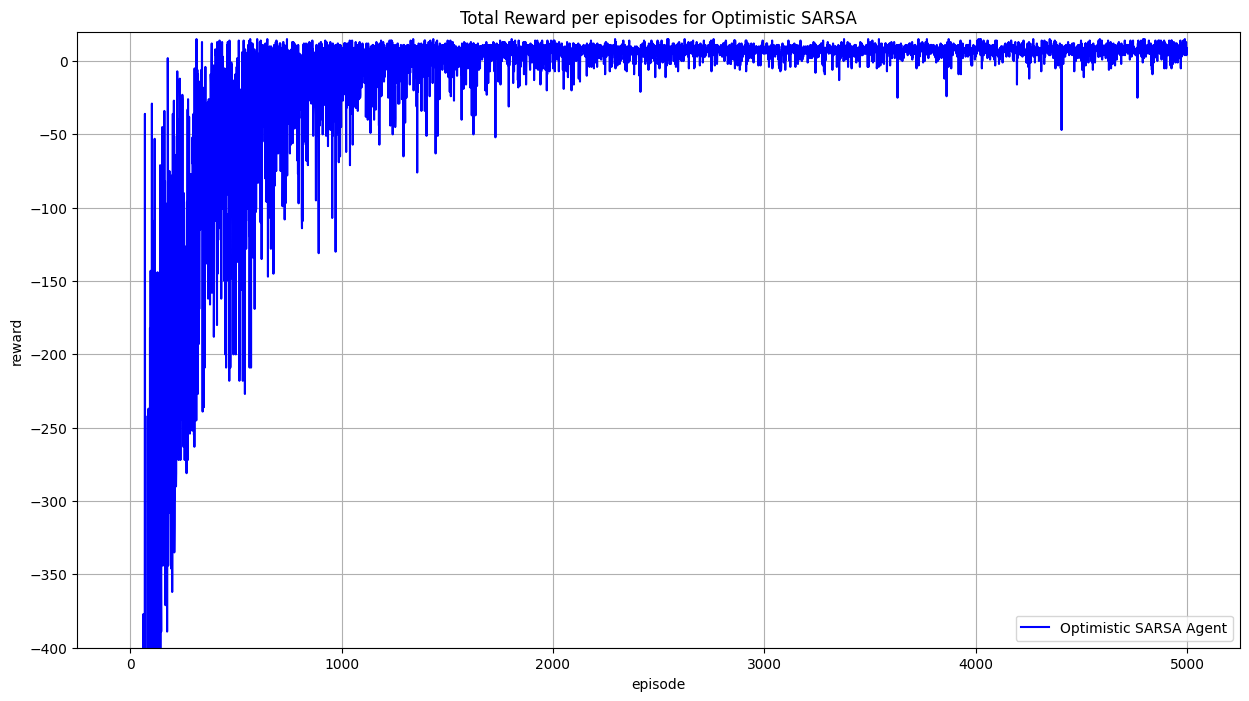

Number of times passenger was dropped off: 4799.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -21.7654
...... running with alpha = 0.1 and gamma = 0.7 ......
Training...
Learning done!


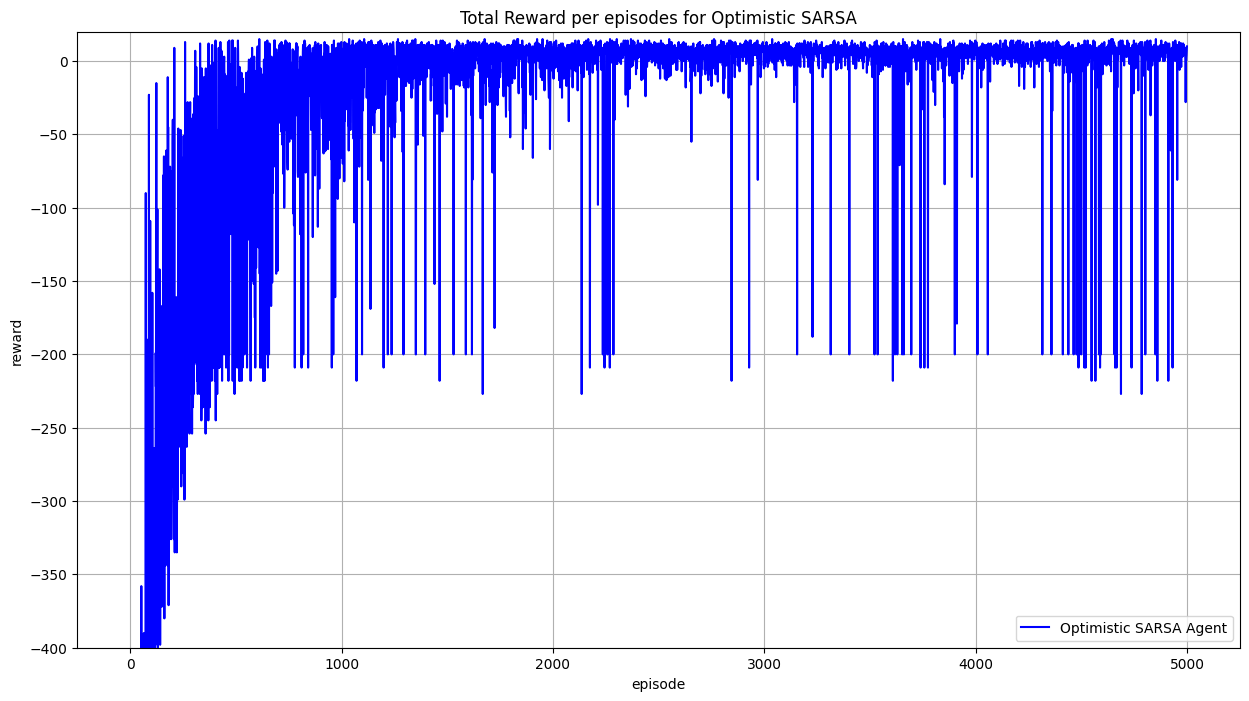

Number of times passenger was dropped off: 4678.0
Max reward: 15.0
Min reward: -866.0
Avg reward: -28.2106
alpha = 0.2
...... running with alpha = 0.2 and gamma = 1 ......
Training...
Learning done!


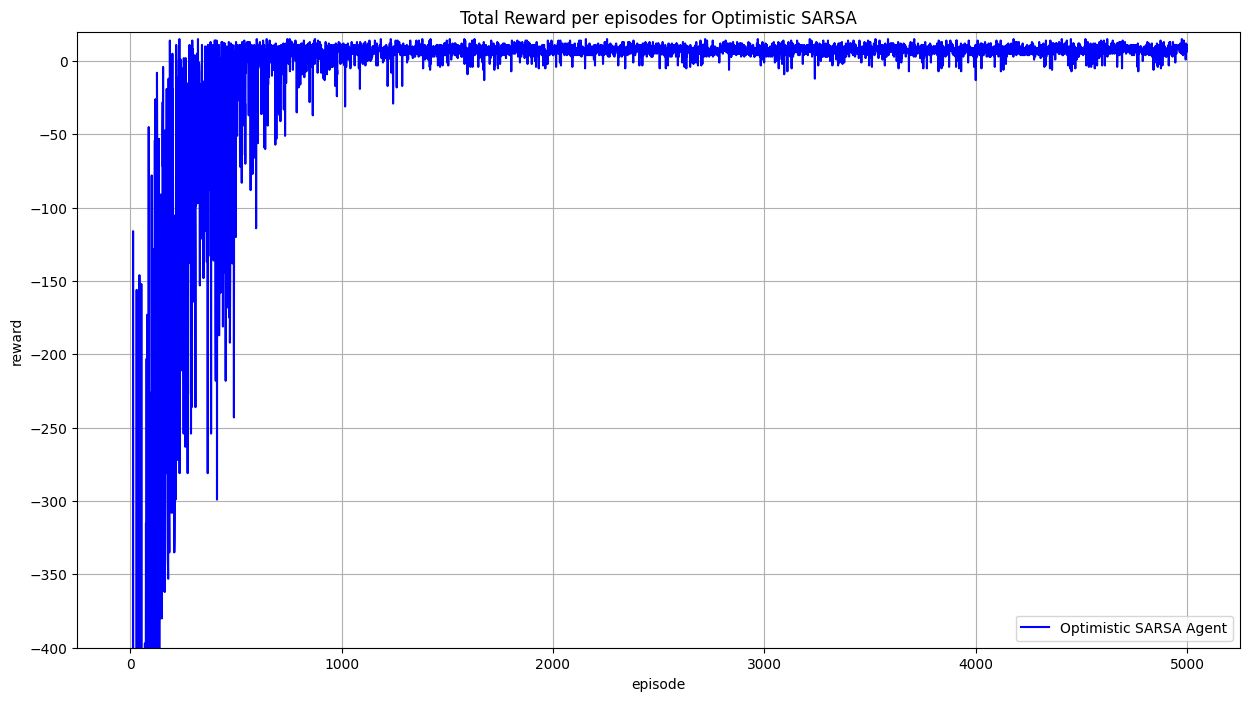

Number of times passenger was dropped off: 4853.0
Max reward: 15.0
Min reward: -848.0
Avg reward: -13.8796
...... running with alpha = 0.2 and gamma = 0.9 ......
Training...
Learning done!


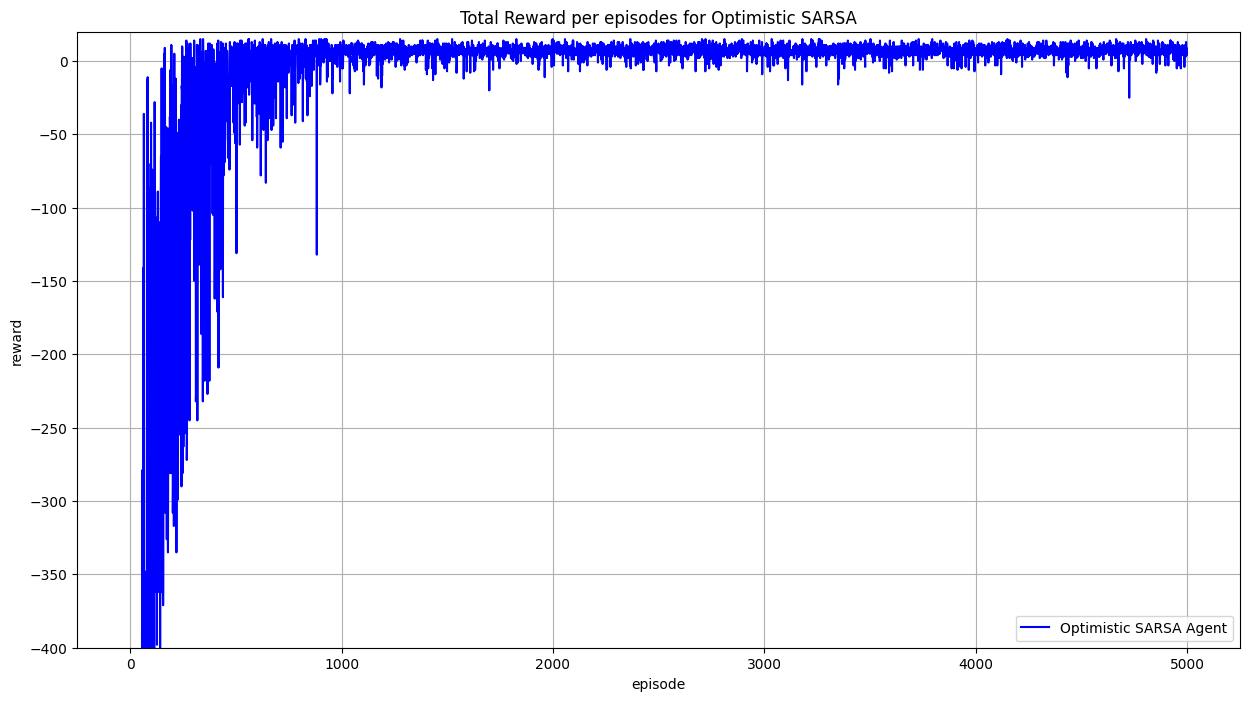

Number of times passenger was dropped off: 4838.0
Max reward: 15.0
Min reward: -893.0
Avg reward: -13.9124
...... running with alpha = 0.2 and gamma = 0.8 ......
Training...
Learning done!


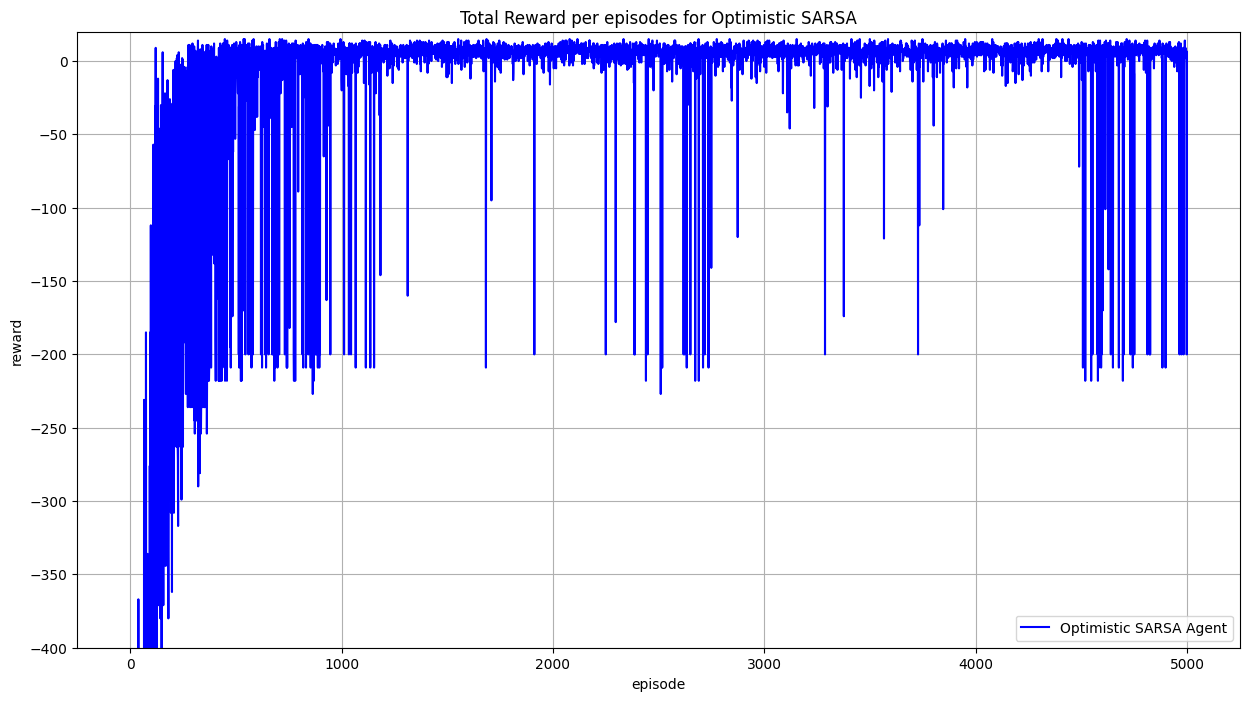

Number of times passenger was dropped off: 4705.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -20.542
...... running with alpha = 0.2 and gamma = 0.7 ......
Training...
Learning done!


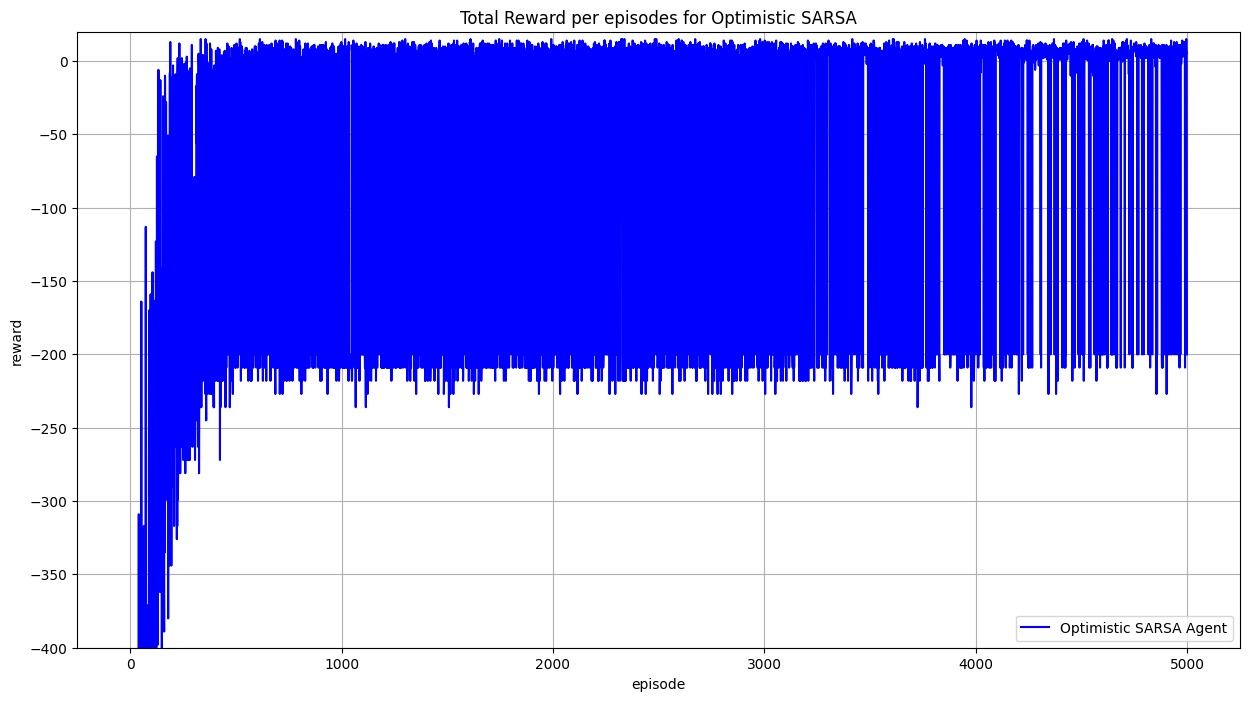

Number of times passenger was dropped off: 3162.0
Max reward: 15.0
Min reward: -947.0
Avg reward: -85.1696
alpha = 0.3
...... running with alpha = 0.3 and gamma = 1 ......
Training...
Learning done!


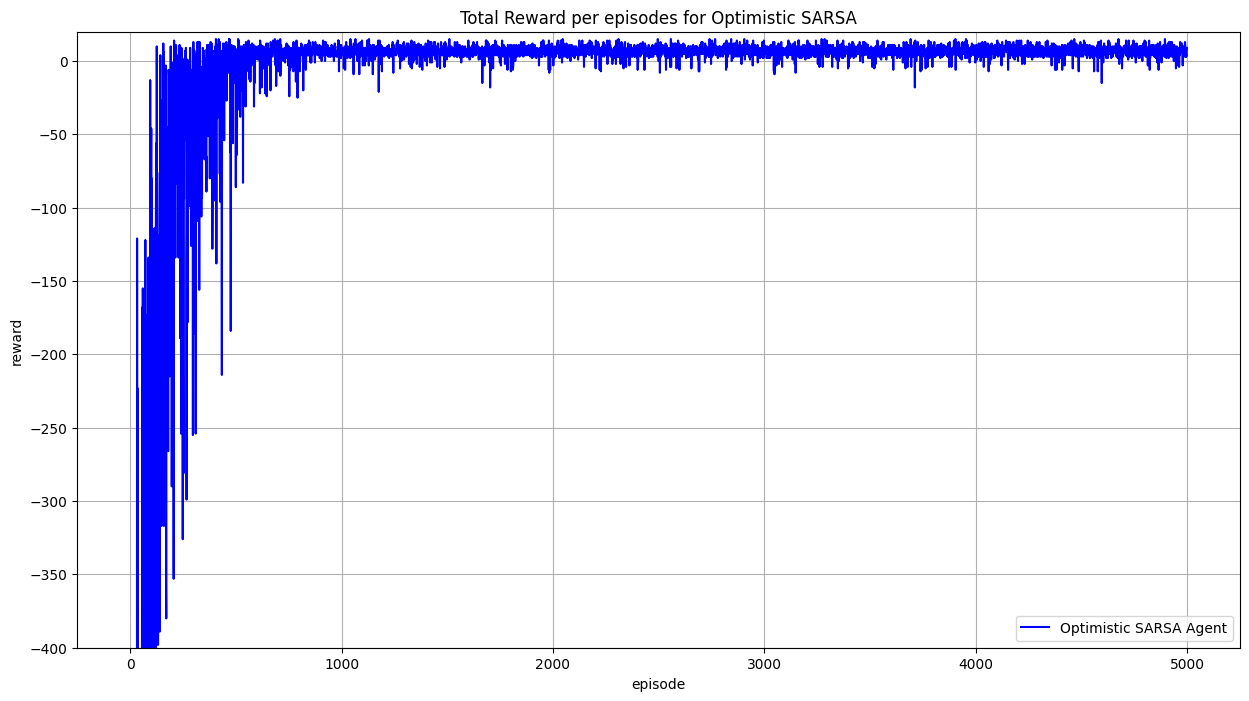

Number of times passenger was dropped off: 4879.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -10.9178
...... running with alpha = 0.3 and gamma = 0.9 ......
Training...
Learning done!


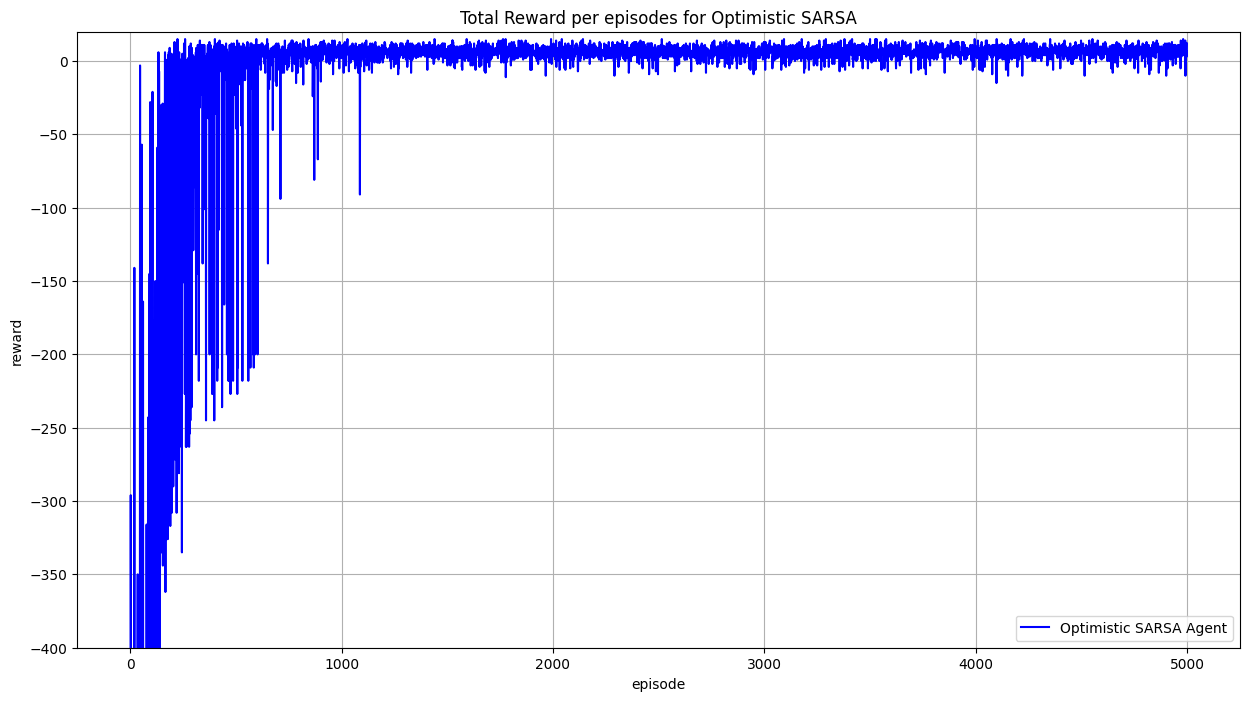

Number of times passenger was dropped off: 4834.0
Max reward: 15.0
Min reward: -848.0
Avg reward: -12.9204
...... running with alpha = 0.3 and gamma = 0.8 ......
Training...
Learning done!


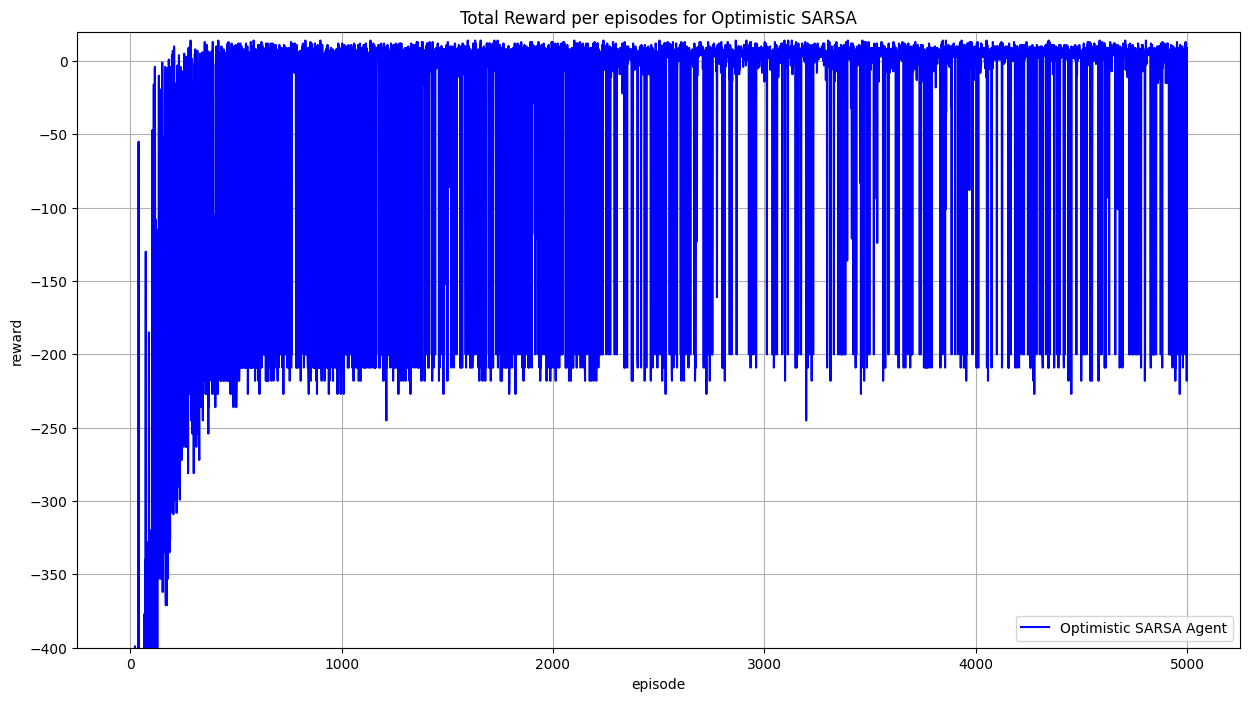

Number of times passenger was dropped off: 3937.0
Max reward: 14.0
Min reward: -875.0
Avg reward: -53.2452
...... running with alpha = 0.3 and gamma = 0.7 ......
Training...
Learning done!


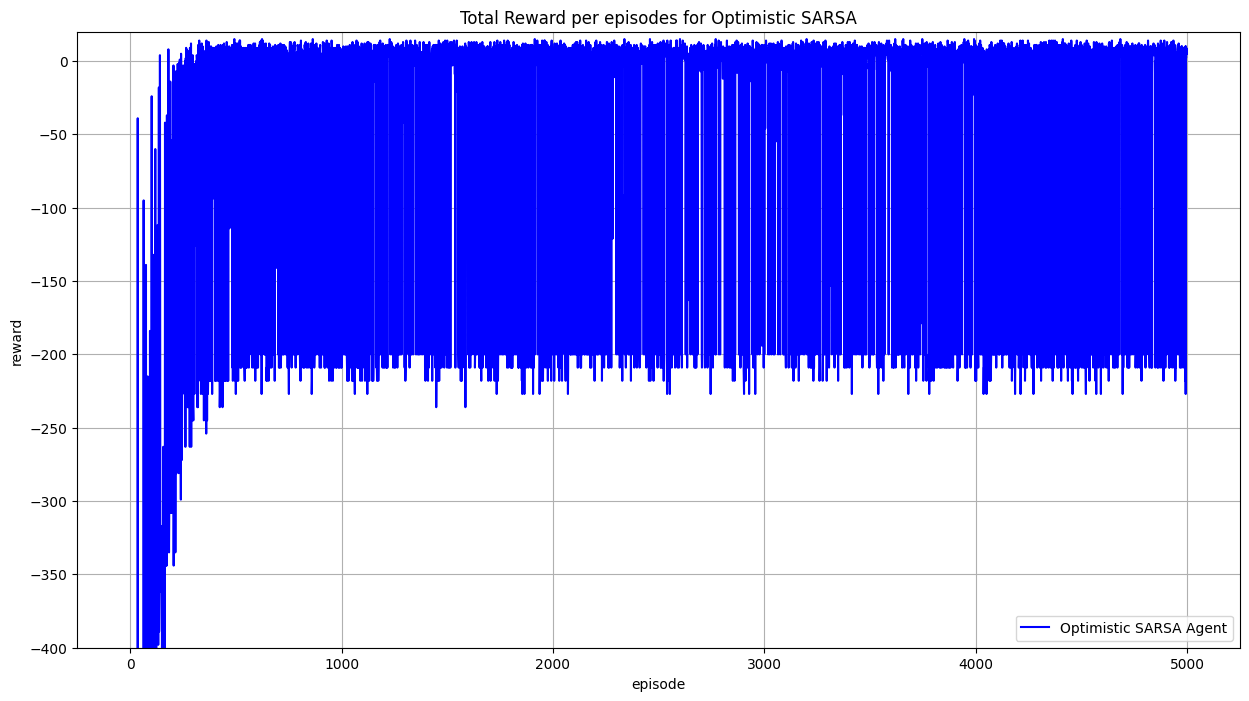

Number of times passenger was dropped off: 3619.0
Max reward: 15.0
Min reward: -830.0
Avg reward: -67.1994
alpha = 0.4
...... running with alpha = 0.4 and gamma = 1 ......
Training...
Learning done!


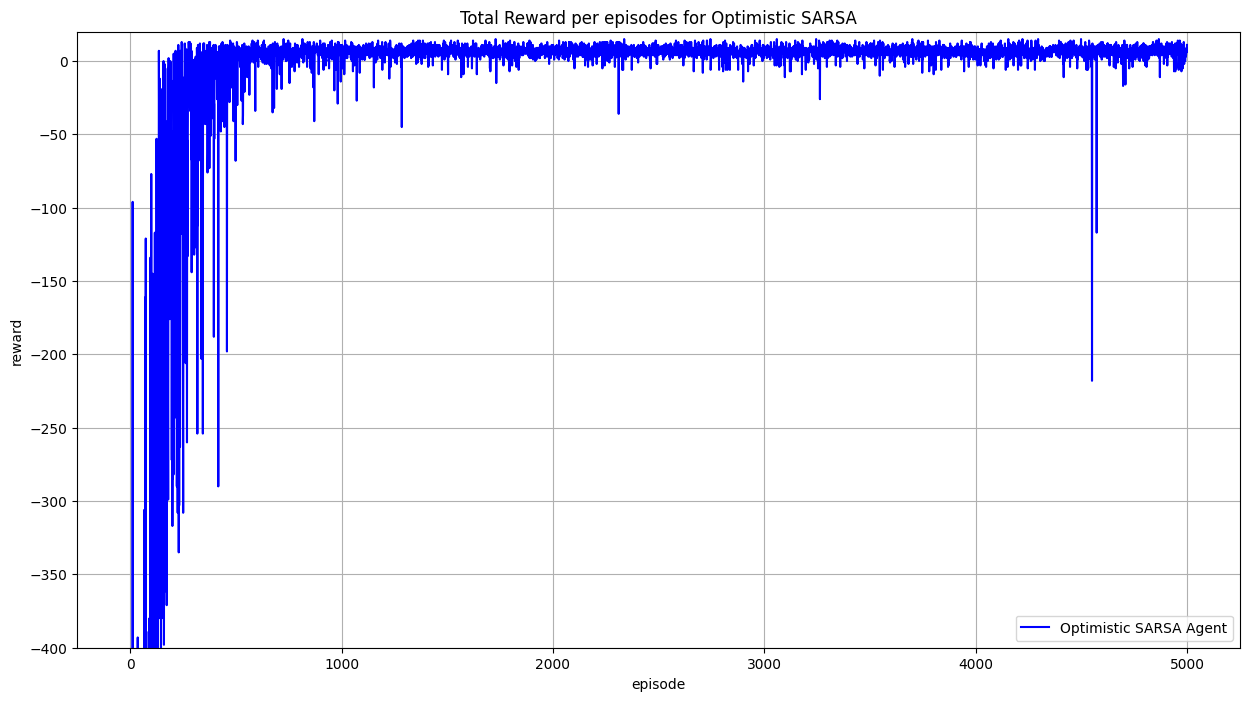

Number of times passenger was dropped off: 4873.0
Max reward: 15.0
Min reward: -830.0
Avg reward: -11.8236
...... running with alpha = 0.4 and gamma = 0.9 ......
Training...
Learning done!


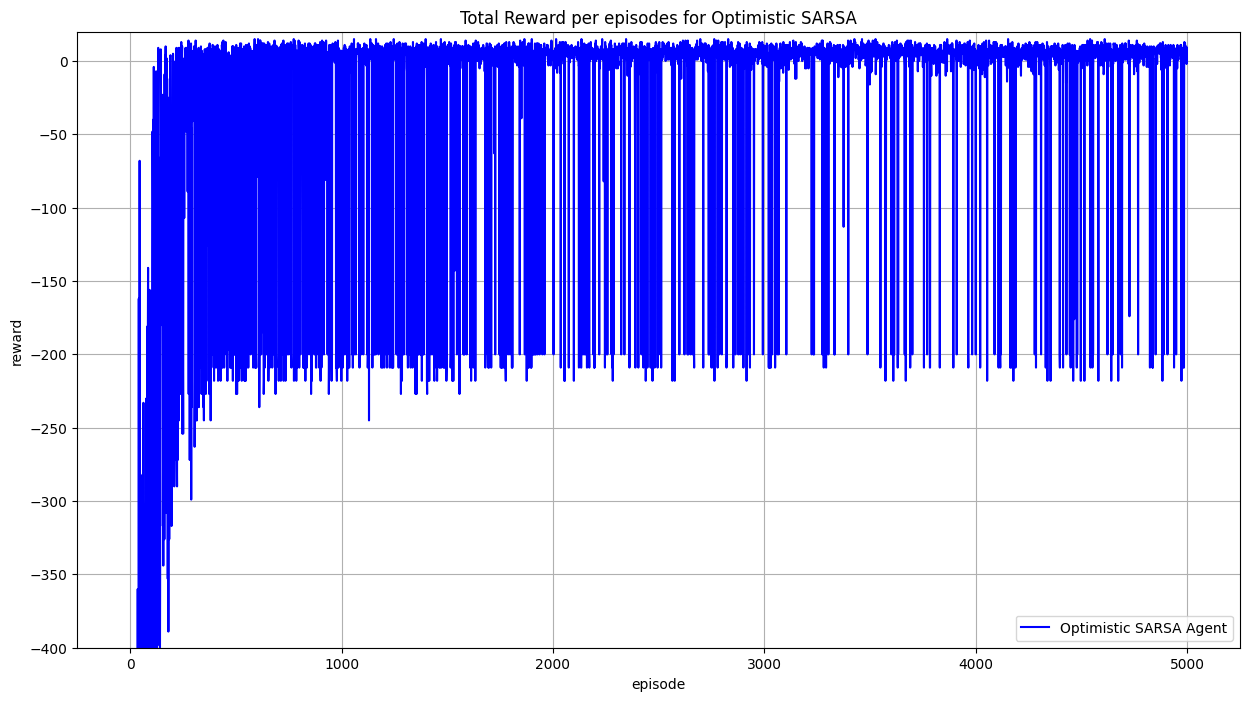

Number of times passenger was dropped off: 4353.0
Max reward: 15.0
Min reward: -866.0
Avg reward: -33.5668
...... running with alpha = 0.4 and gamma = 0.8 ......
Training...
Learning done!


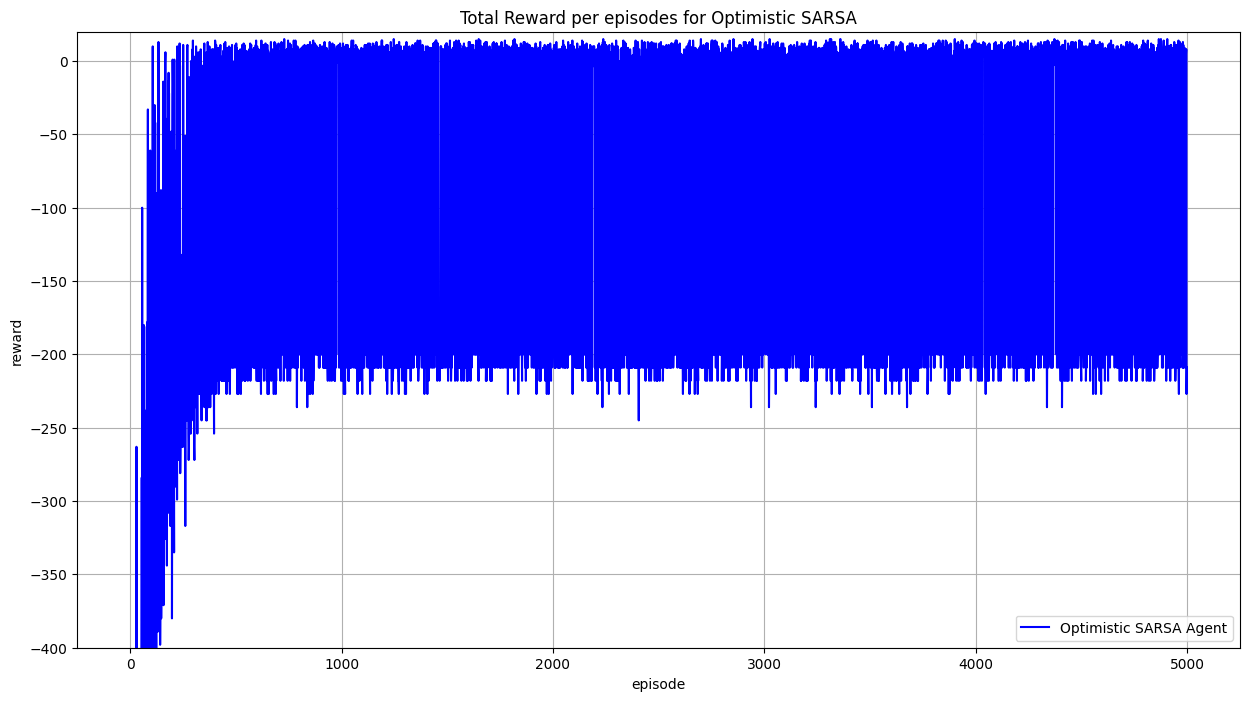

Number of times passenger was dropped off: 2601.0
Max reward: 15.0
Min reward: -902.0
Avg reward: -108.4428
...... running with alpha = 0.4 and gamma = 0.7 ......
Training...
Learning done!


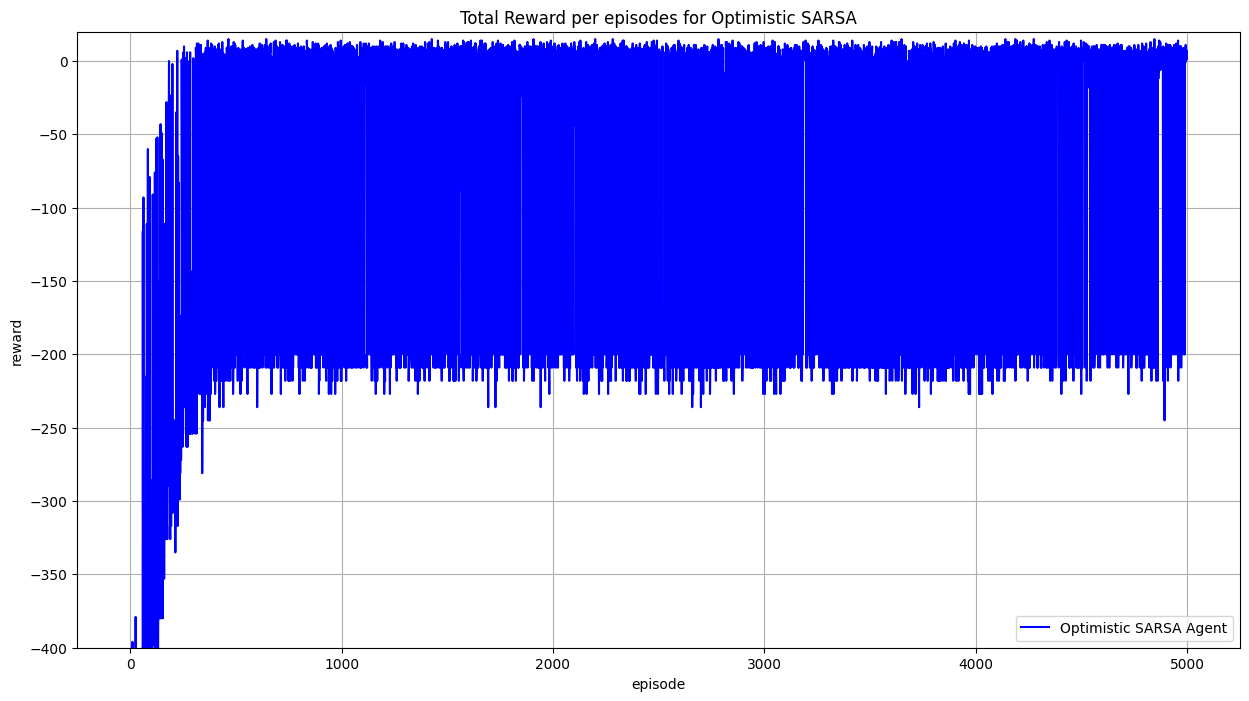

Number of times passenger was dropped off: 2854.0
Max reward: 15.0
Min reward: -875.0
Avg reward: -99.7226


In [9]:
#trying optimistic Sarsa_agent

OIV_SARSA_rewards = pd.DataFrame()
performance = {"alpha":[],"gamma":[],"avg_reward":[]}

for i in [0.1,0.2,0.3,0.4]:
    print(f"alpha = {i}")
    for j in [1,0.9,0.8,0.7]:
        print(f"...... running with alpha = {i} and gamma = {j} ......")
        alpha = i
        gamma = j
        sarsa_agent = SarsaAgent(max_episodes, 
                max_steps, 
                test_episodes, 
                alpha = i, 
                gamma = j, 
                epsilon = 1, 
                decay_rate = 0.01,
                optimistic = True
                )

        sarsa_agent.run()
        
        name = "a"+str(i)+"_g"+str(j)
        OIV_SARSA_rewards[name] = pd.Series(sarsa_agent.reward_list)
        sarsa_agent.export_csv(f"sarsa_a{i}_g{j}")
        performance["alpha"].append(i)
        performance["gamma"].append(j)
        performance["avg_reward"].append((sum(sarsa_agent.reward_list)/sarsa_agent.max_episodes))
        
        
OIV_SARSA_rewards.to_csv("optimistic_sarsa.csv")

# Testing Q Agent for multiple epsilons, alpha and gamma

epsilon = 1
Training....
Learning done!


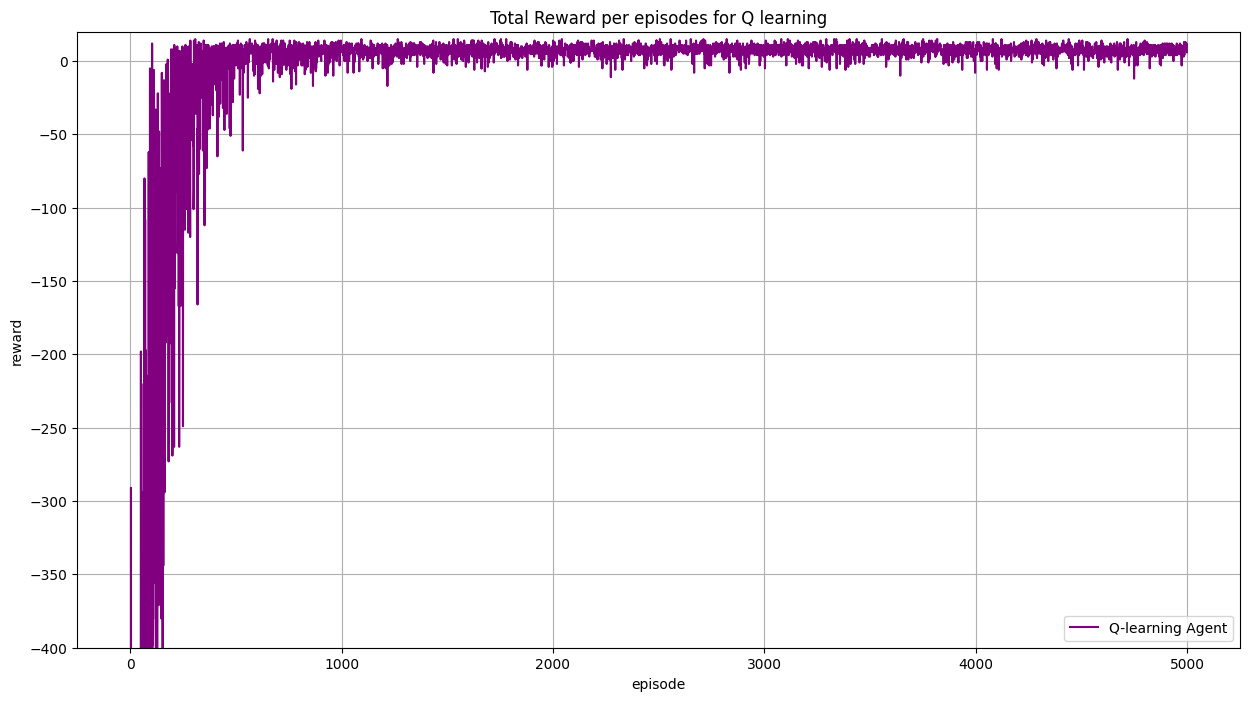

Number of times passenger was dropped off: 4905.0
Max reward: 15.0
Min reward: -875.0
Avg reward: -9.0206
epsilon = 0.9
Training....
Learning done!


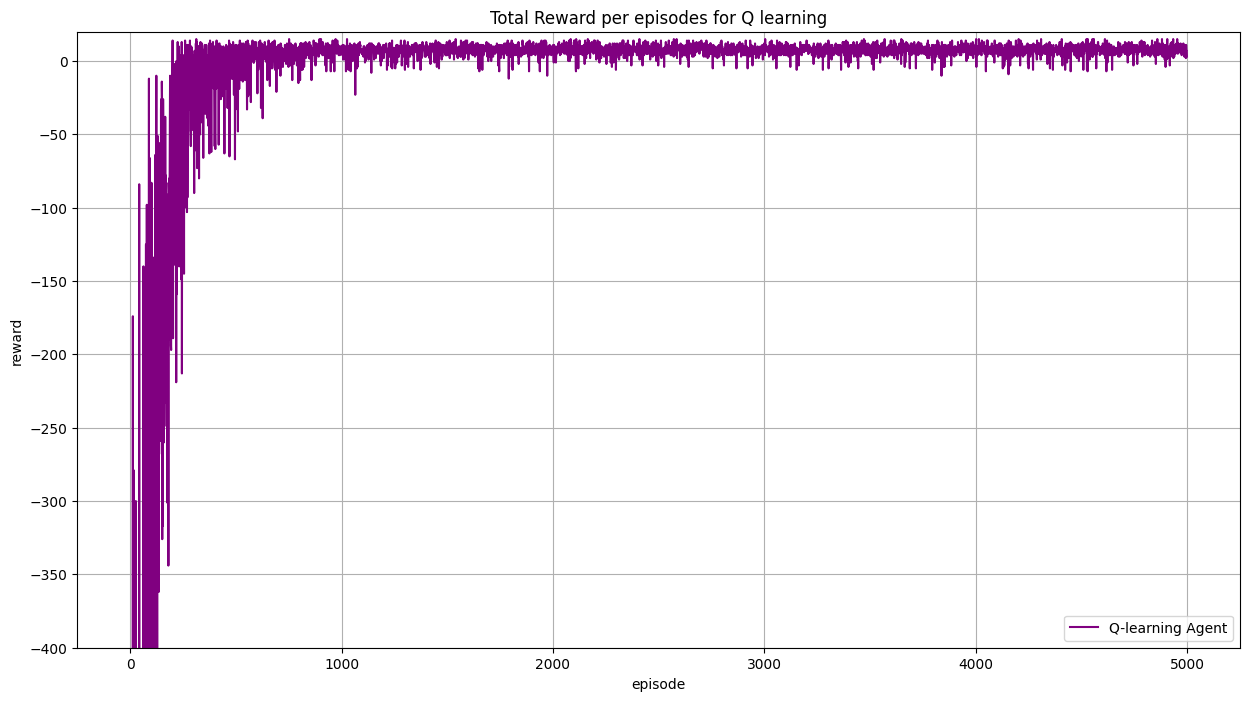

Number of times passenger was dropped off: 4905.0
Max reward: 15.0
Min reward: -875.0
Avg reward: -9.039
epsilon = 0.8
Training....
Learning done!


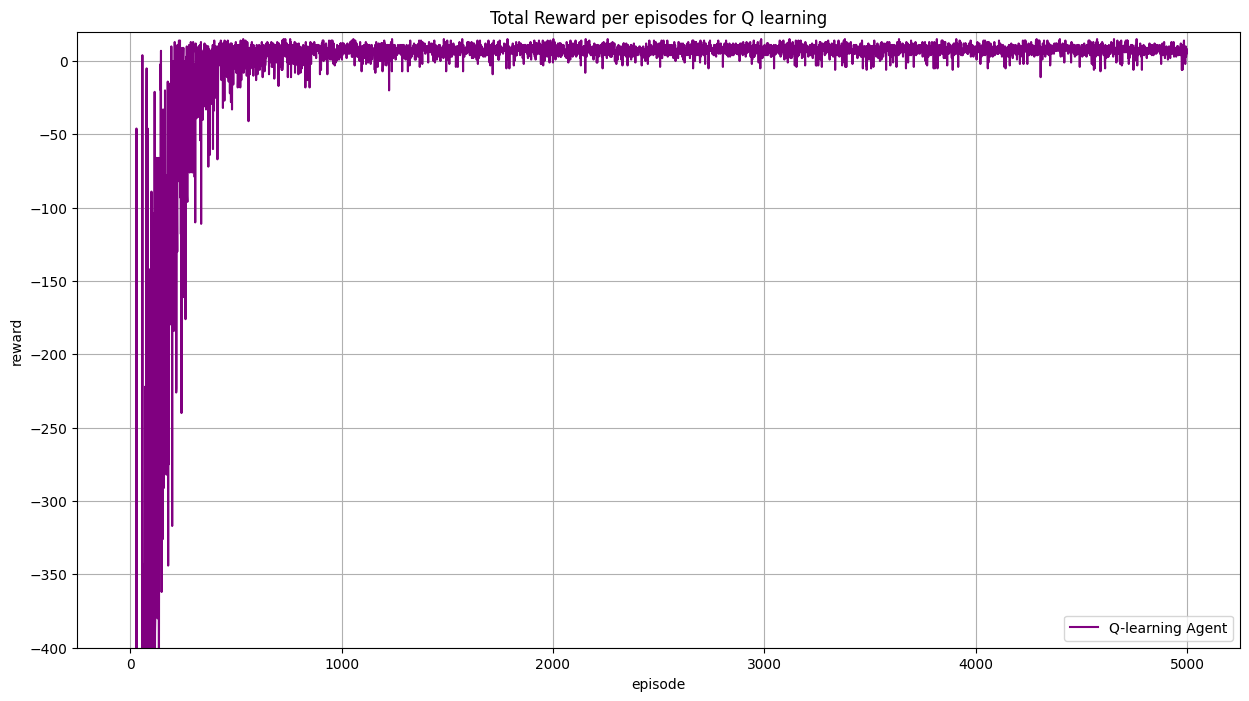

Number of times passenger was dropped off: 4897.0
Max reward: 15.0
Min reward: -893.0
Avg reward: -9.6974
epsilon = 0.7
Training....
Learning done!


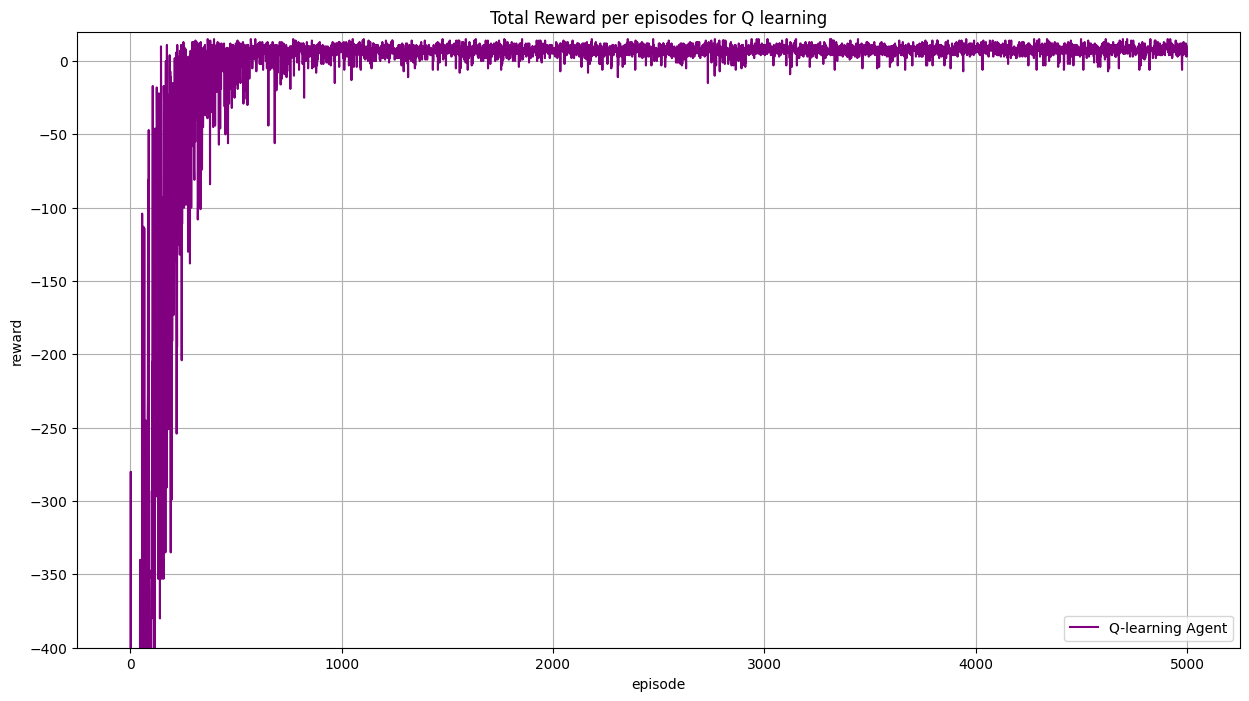

Number of times passenger was dropped off: 4905.0
Max reward: 15.0
Min reward: -848.0
Avg reward: -9.2596


In [10]:
for i in [1,0.9,0.8,0.7]:
        epsilon = i
        print(f"epsilon = {epsilon}")
        Q_agent = Q_Agent(max_episodes, 
                max_steps, 
                test_episodes, 
                alpha, 
                gamma, 
                epsilon = epsilon, 
                decay_rate = decay_rate,
                optimistic= False)

        Q_agent.run()

In [11]:
epsilon = 0.9
#based on results above

# Sarsa Class and Testing

Training...
Learning done!


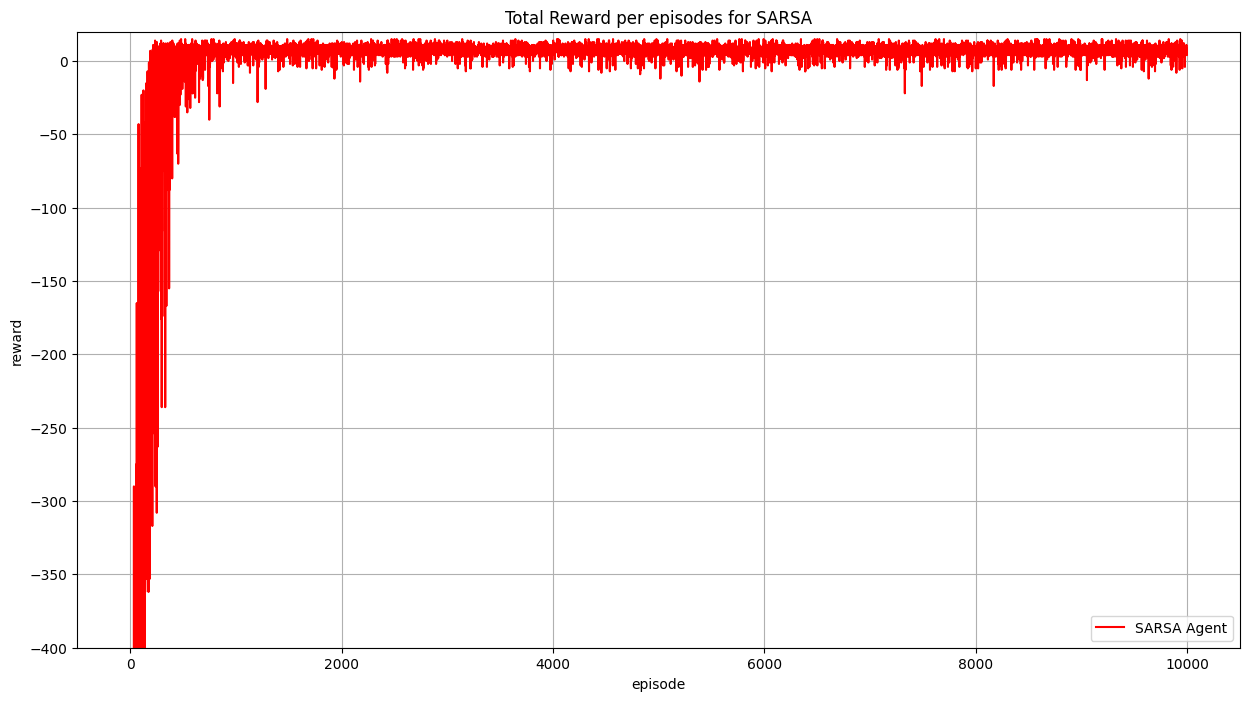

Number of times passenger was dropped off: 9882.0
Max reward: 15.0
Min reward: -866.0
Avg reward: -1.5643


In [12]:
#testing 

sarsa_OIV_agent = SarsaAgent(max_episodes = 10000, 
                max_steps = 200, 
                test_episodes = 100, 
                alpha = 0.3, 
                gamma = 1, 
                epsilon = 1, 
                decay_rate = 0.01,
                optimistic = False)
sarsa_OIV_agent.run()

# Testing different alphas and gammas for SARSA Agent.

alpha = 0.1
...... running with alpha = 0.1 and gamma = 1 ......
Training...
Learning done!


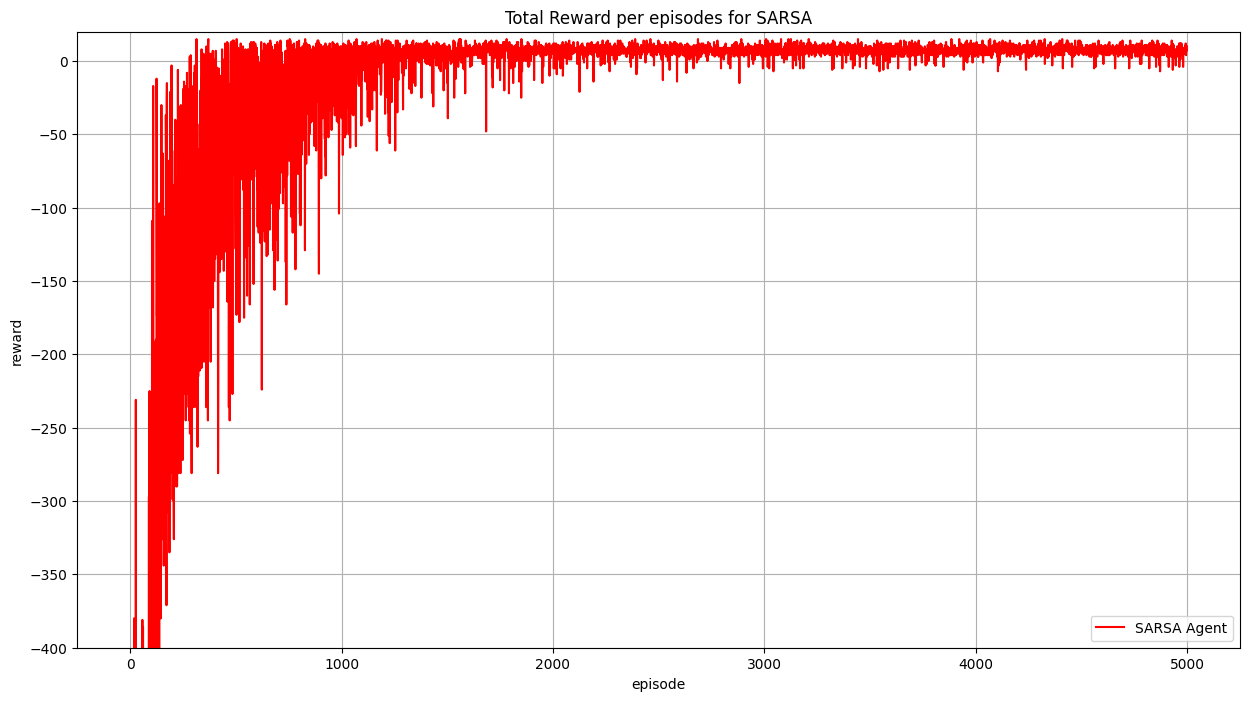

Number of times passenger was dropped off: 4822.0
Max reward: 15.0
Min reward: -884.0
Avg reward: -20.1392
...... running with alpha = 0.1 and gamma = 0.9 ......
Training...
Learning done!


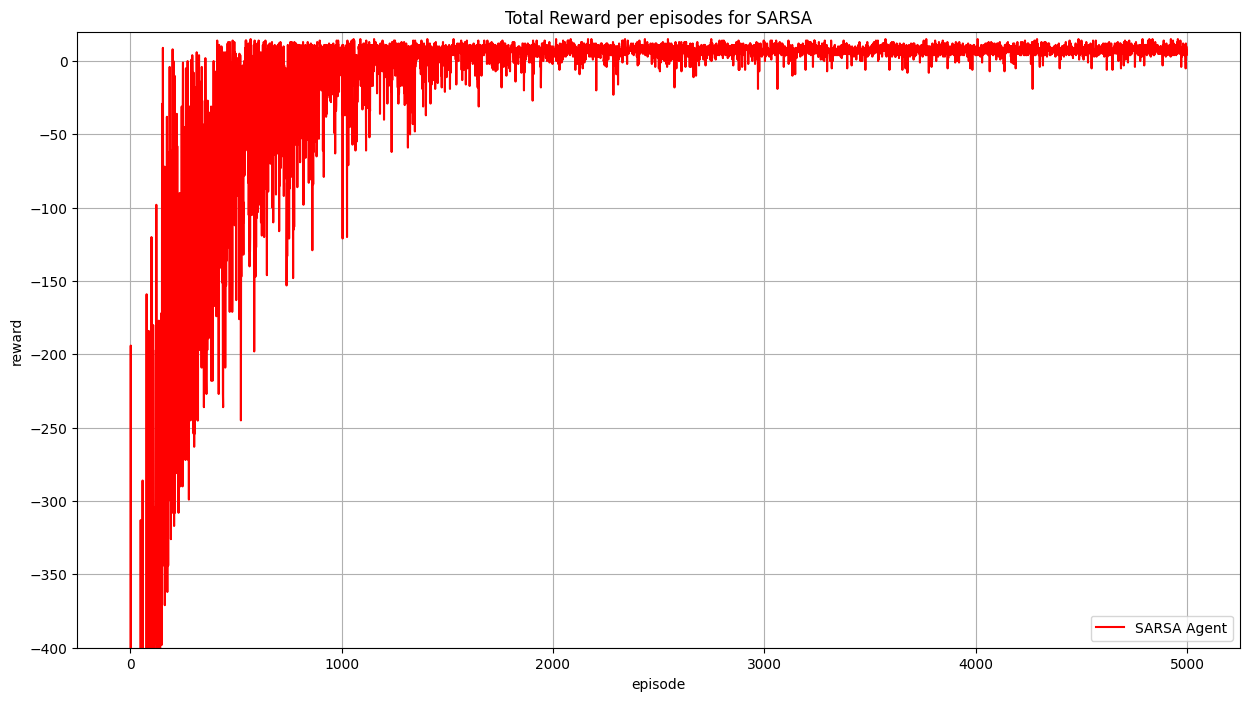

Number of times passenger was dropped off: 4800.0
Max reward: 15.0
Min reward: -875.0
Avg reward: -21.9198
...... running with alpha = 0.1 and gamma = 0.8 ......
Training...
Learning done!


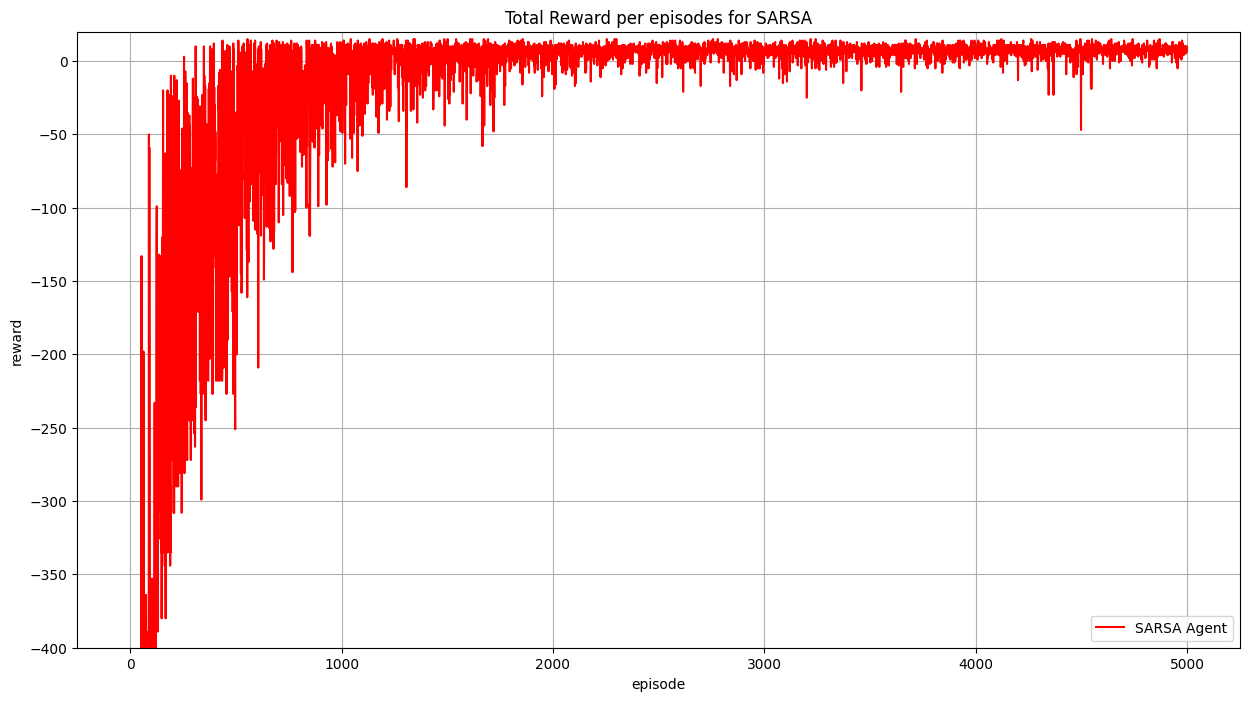

Number of times passenger was dropped off: 4781.0
Max reward: 15.0
Min reward: -956.0
Avg reward: -23.2608
...... running with alpha = 0.1 and gamma = 0.7 ......
Training...
Learning done!


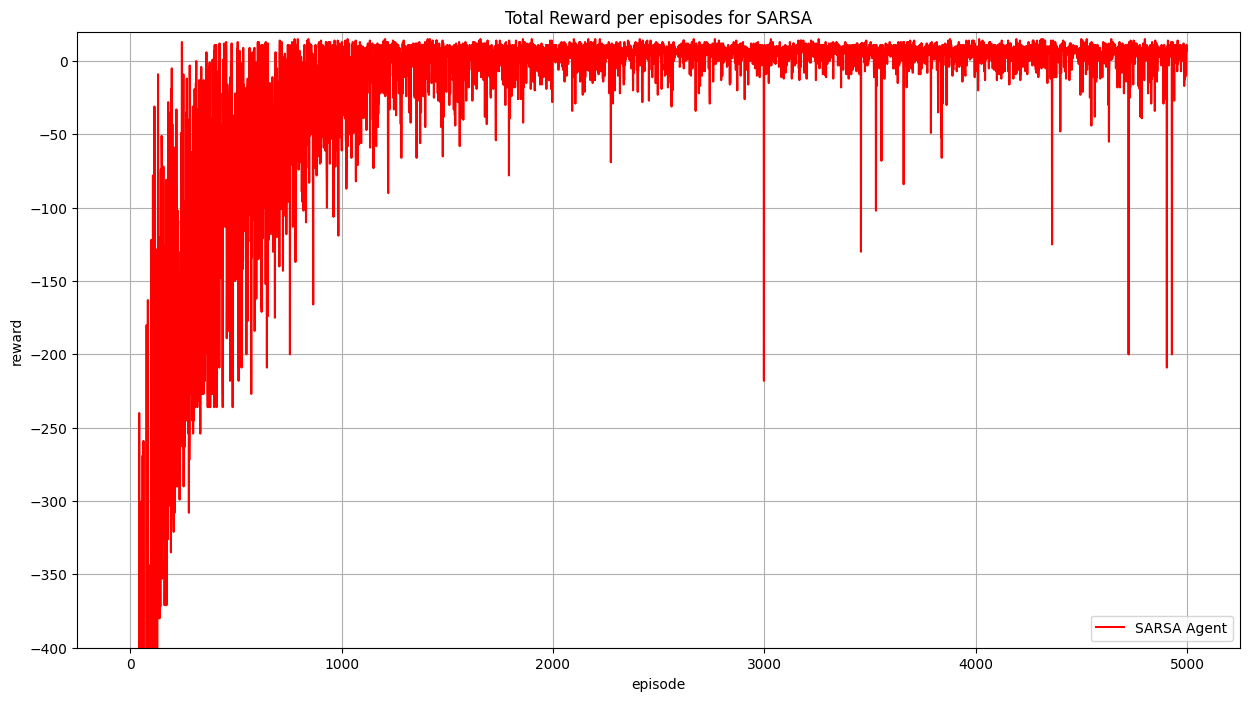

Number of times passenger was dropped off: 4764.0
Max reward: 15.0
Min reward: -821.0
Avg reward: -26.202
alpha = 0.2
...... running with alpha = 0.2 and gamma = 1 ......
Training...
Learning done!


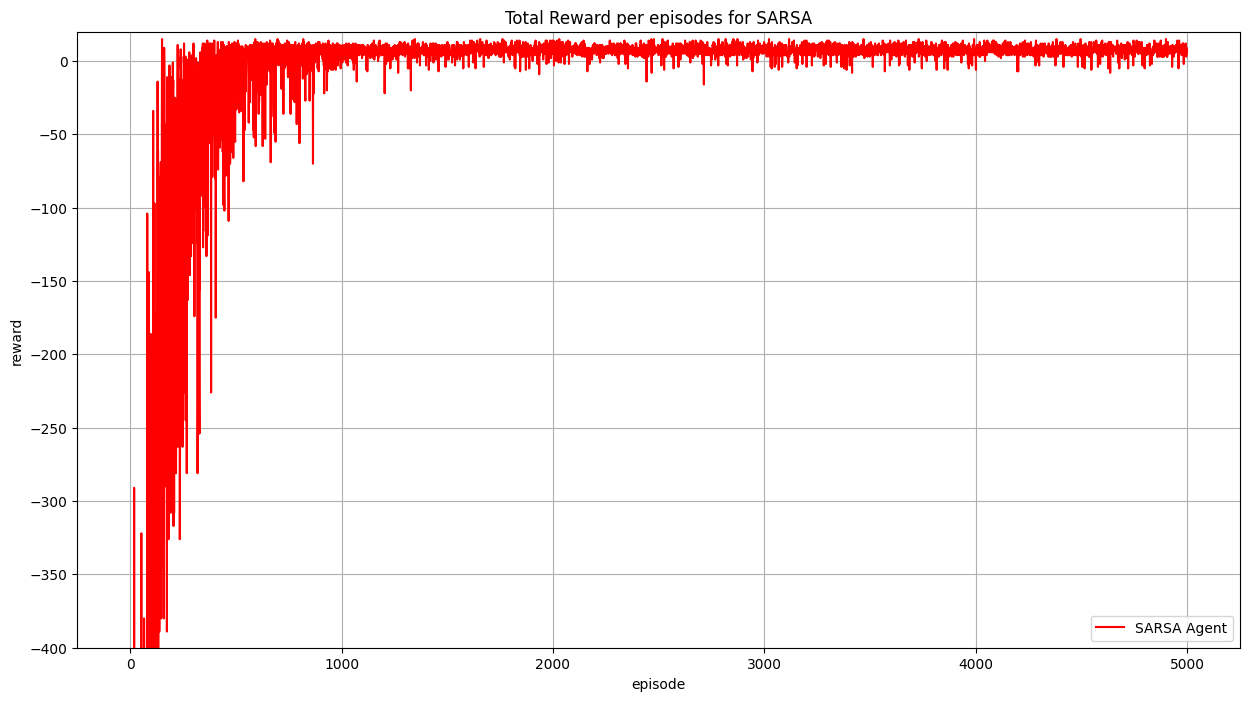

Number of times passenger was dropped off: 4853.0
Max reward: 15.0
Min reward: -884.0
Avg reward: -13.5142
...... running with alpha = 0.2 and gamma = 0.9 ......
Training...
Learning done!


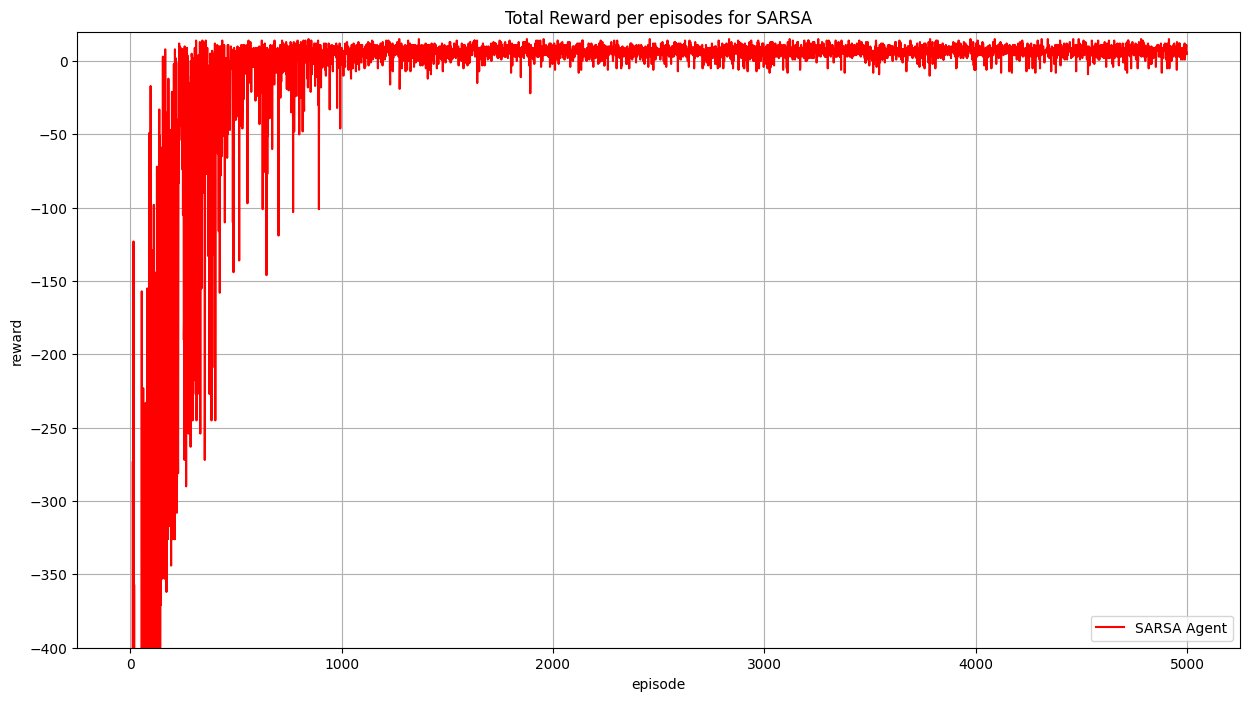

Number of times passenger was dropped off: 4837.0
Max reward: 15.0
Min reward: -884.0
Avg reward: -14.473
...... running with alpha = 0.2 and gamma = 0.8 ......
Training...
Learning done!


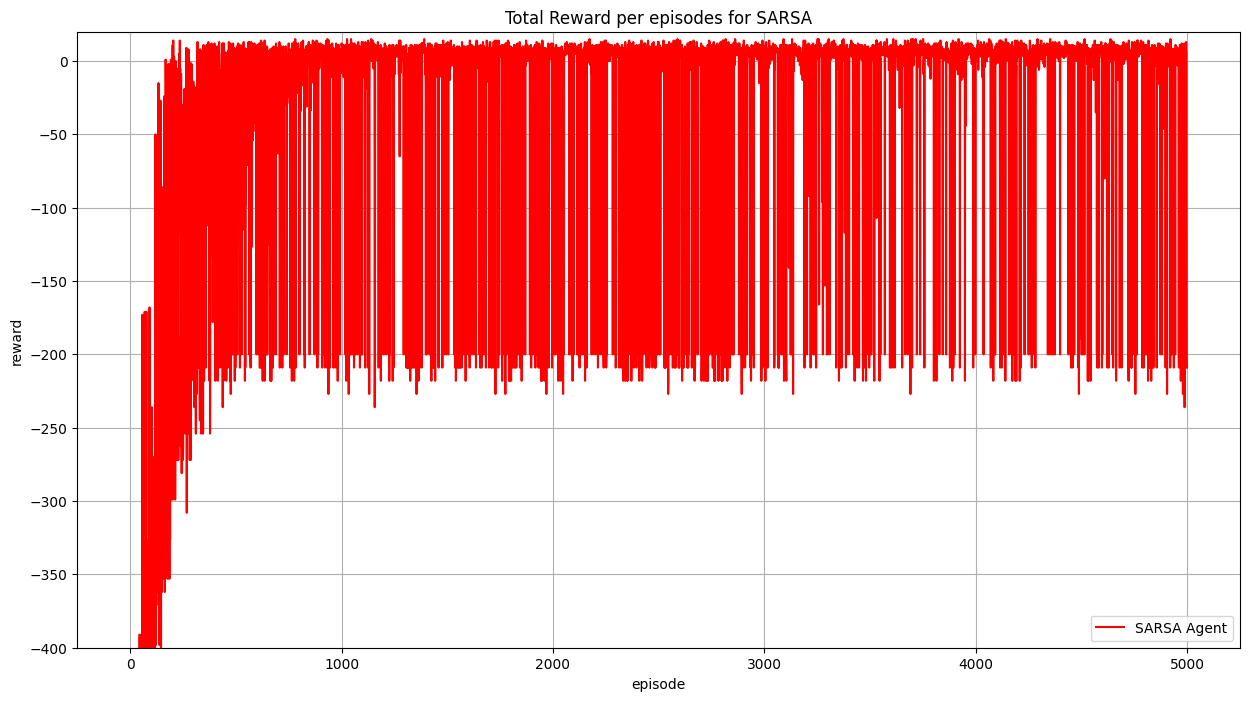

Number of times passenger was dropped off: 4213.0
Max reward: 15.0
Min reward: -866.0
Avg reward: -41.8556
...... running with alpha = 0.2 and gamma = 0.7 ......
Training...
Learning done!


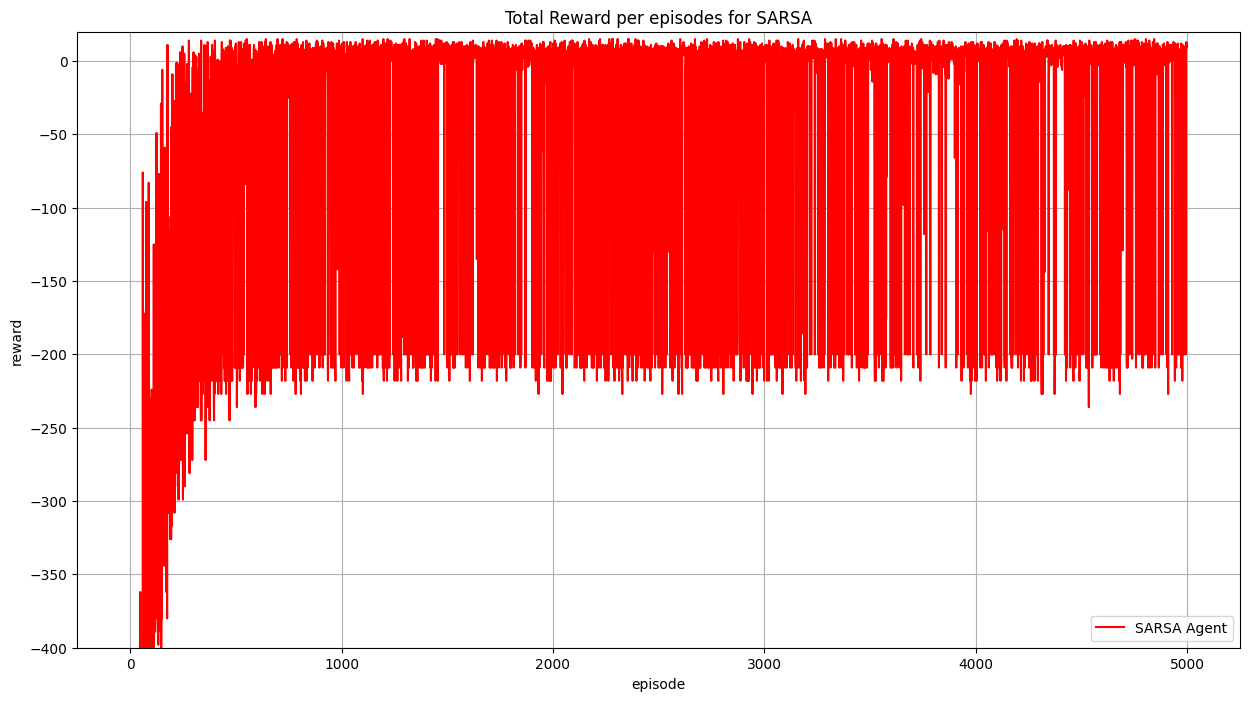

Number of times passenger was dropped off: 3788.0
Max reward: 15.0
Min reward: -893.0
Avg reward: -60.9186
alpha = 0.3
...... running with alpha = 0.3 and gamma = 1 ......
Training...
Learning done!


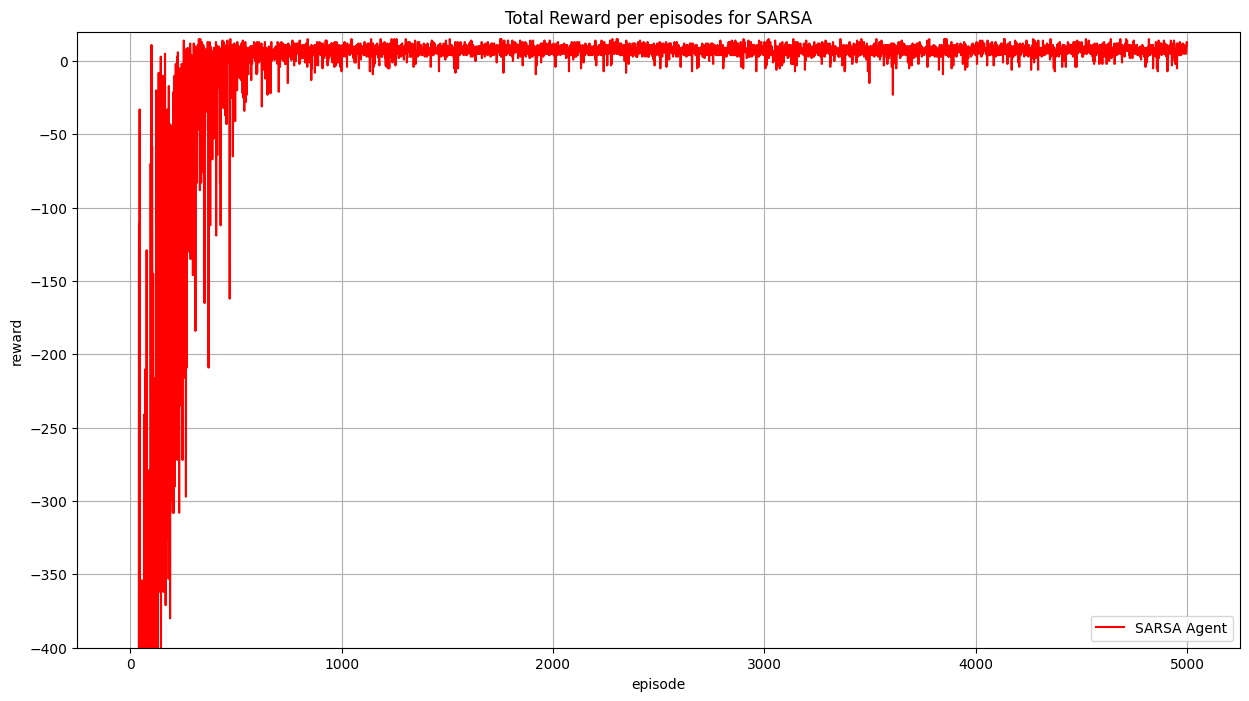

Number of times passenger was dropped off: 4871.0
Max reward: 15.0
Min reward: -839.0
Avg reward: -11.282
...... running with alpha = 0.3 and gamma = 0.9 ......
Training...
Learning done!


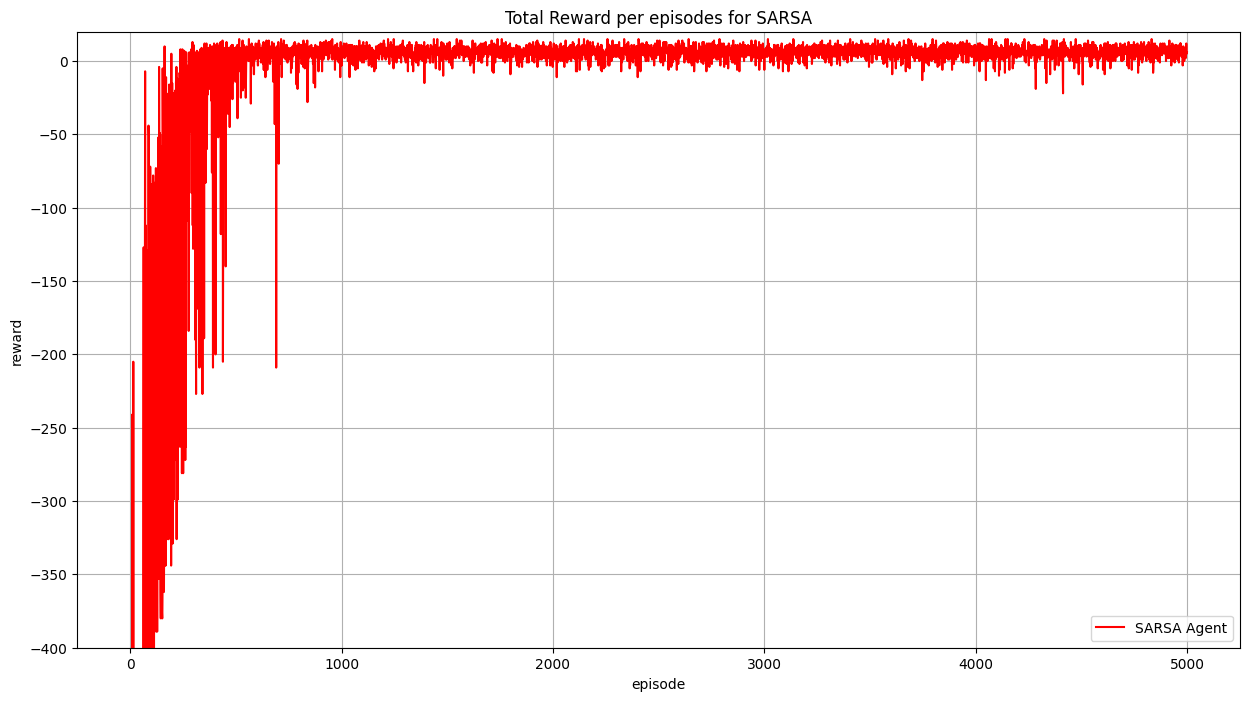

Number of times passenger was dropped off: 4855.0
Max reward: 15.0
Min reward: -803.0
Avg reward: -12.4172
...... running with alpha = 0.3 and gamma = 0.8 ......
Training...
Learning done!


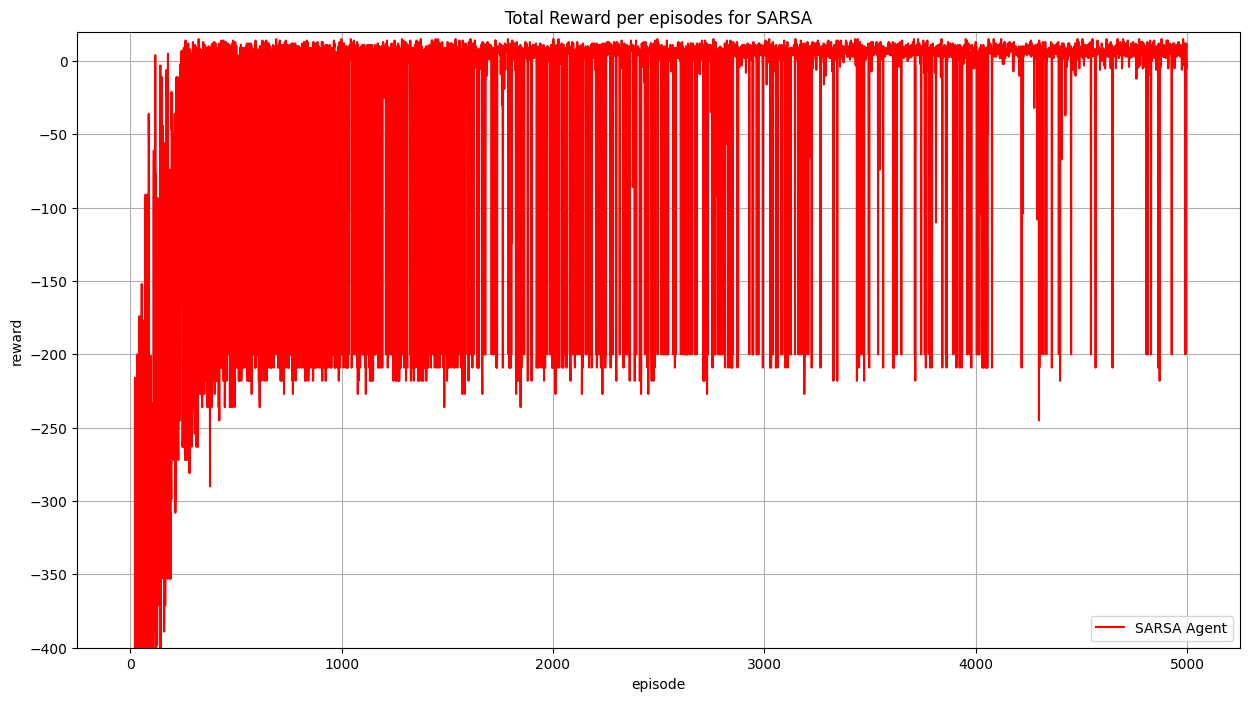

Number of times passenger was dropped off: 4141.0
Max reward: 15.0
Min reward: -884.0
Avg reward: -42.9016
...... running with alpha = 0.3 and gamma = 0.7 ......
Training...
Learning done!


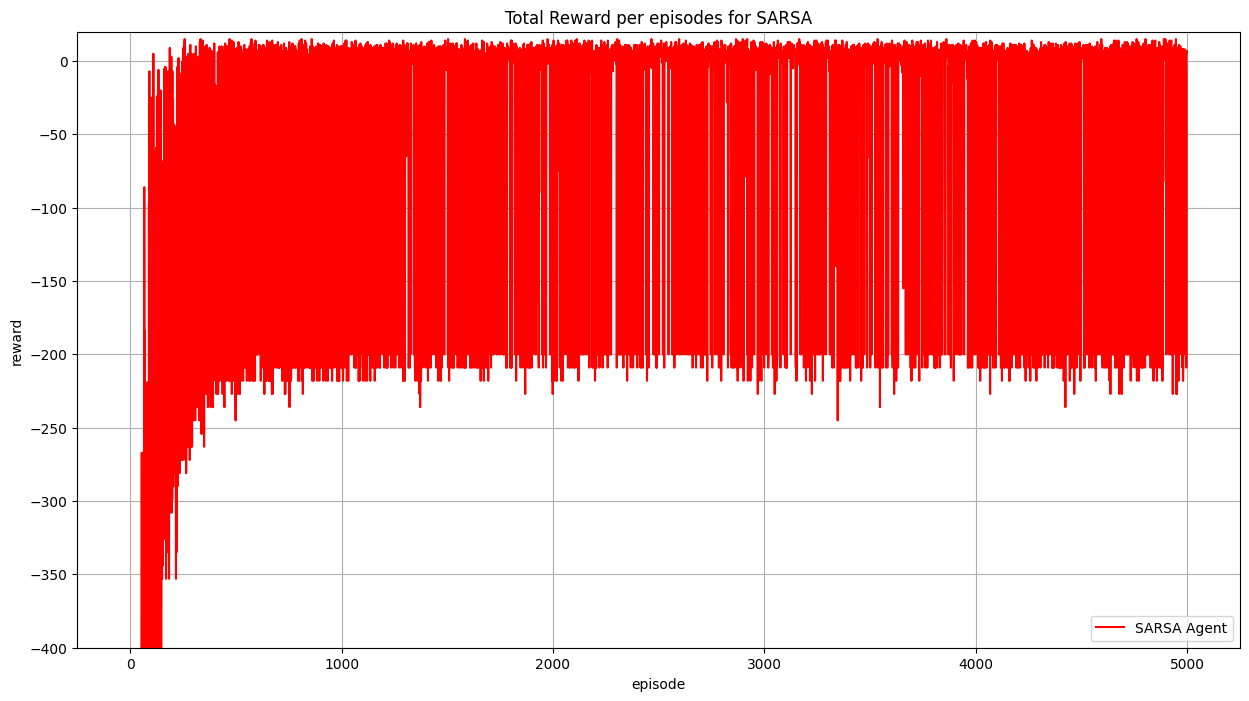

Number of times passenger was dropped off: 3530.0
Max reward: 15.0
Min reward: -830.0
Avg reward: -70.6762


In [13]:
alpha = 0.1
gamma = 0.8

SARSA_rewards = pd.DataFrame()
performance = {"alpha":[],"gamma":[],"avg_reward":[]}

for i in [0.1,0.2,0.3]:
    print(f"alpha = {i}")
    for j in [1,0.9,0.8,0.7]:
        print(f"...... running with alpha = {i} and gamma = {j} ......")
        alpha = i
        gamma = j
        sarsa_agent = SarsaAgent(max_episodes, 
                max_steps, 
                test_episodes, 
                alpha = i, 
                gamma = j, 
                epsilon = 1, 
                decay_rate = 0.01,
                optimistic = False
                )

        sarsa_agent.run()
        
        name = "a"+str(i)+"_g"+str(j)
        SARSA_rewards[name] = pd.Series(sarsa_agent.reward_list)
        sarsa_agent.export_csv(f"sarsa_a{i}_g{j}")
        performance["alpha"].append(i)
        performance["gamma"].append(j)
        performance["avg_reward"].append((sum(sarsa_agent.reward_list)/sarsa_agent.max_episodes))
        
        
SARSA_rewards.to_csv("sarsa.csv")




In [14]:
performance=pd.DataFrame.from_dict(performance)

performance.to_csv("sarsa_performance.csv",index = False)

In [15]:
performance

alpha  gamma  avg_reward
0     0.1    1.0    -20.1392
1     0.1    0.9    -21.9198
2     0.1    0.8    -23.2608
3     0.1    0.7    -26.2020
4     0.2    1.0    -13.5142
5     0.2    0.9    -14.4730
6     0.2    0.8    -41.8556
7     0.2    0.7    -60.9186
8     0.3    1.0    -11.2820
9     0.3    0.9    -12.4172
10    0.3    0.8    -42.9016
11    0.3    0.7    -70.6762

best algorithm : alpha = 0.3 and gamma = 1.0

## Testing different alphas and gammas for Q Learning Agent

alpha = 0.1
...... running with alpha = 0.1 and gamma = 1 ......
Training....
Learning done!


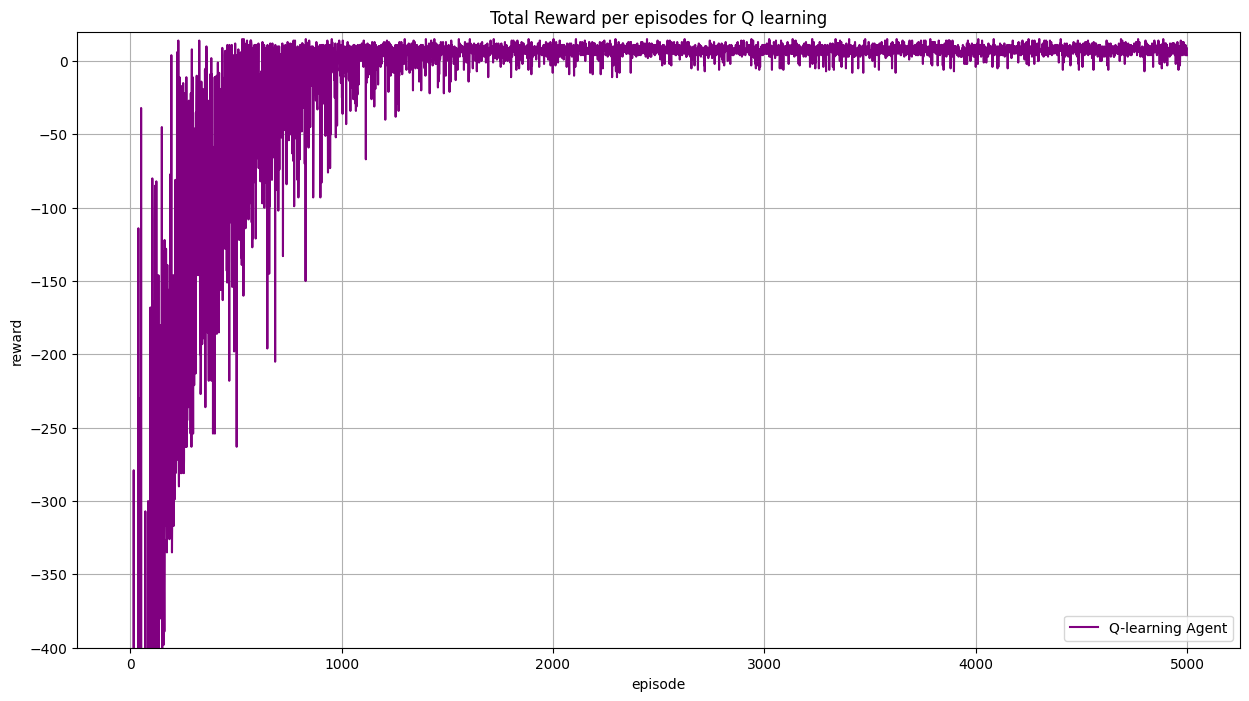

Number of times passenger was dropped off: 4807.0
Max reward: 15.0
Min reward: -938.0
Avg reward: -20.3486
...... running with alpha = 0.1 and gamma = 0.9 ......
Training....
Learning done!


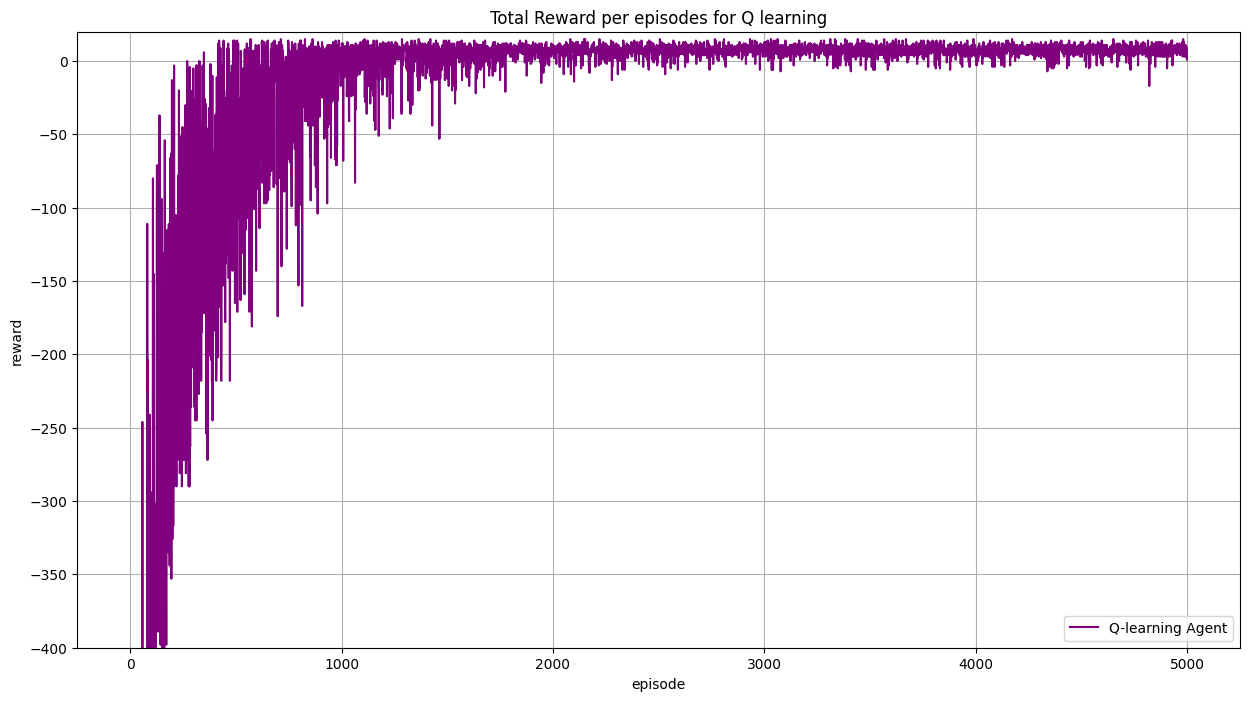

Number of times passenger was dropped off: 4801.0
Max reward: 15.0
Min reward: -902.0
Avg reward: -21.81
...... running with alpha = 0.1 and gamma = 0.8 ......
Training....
Learning done!


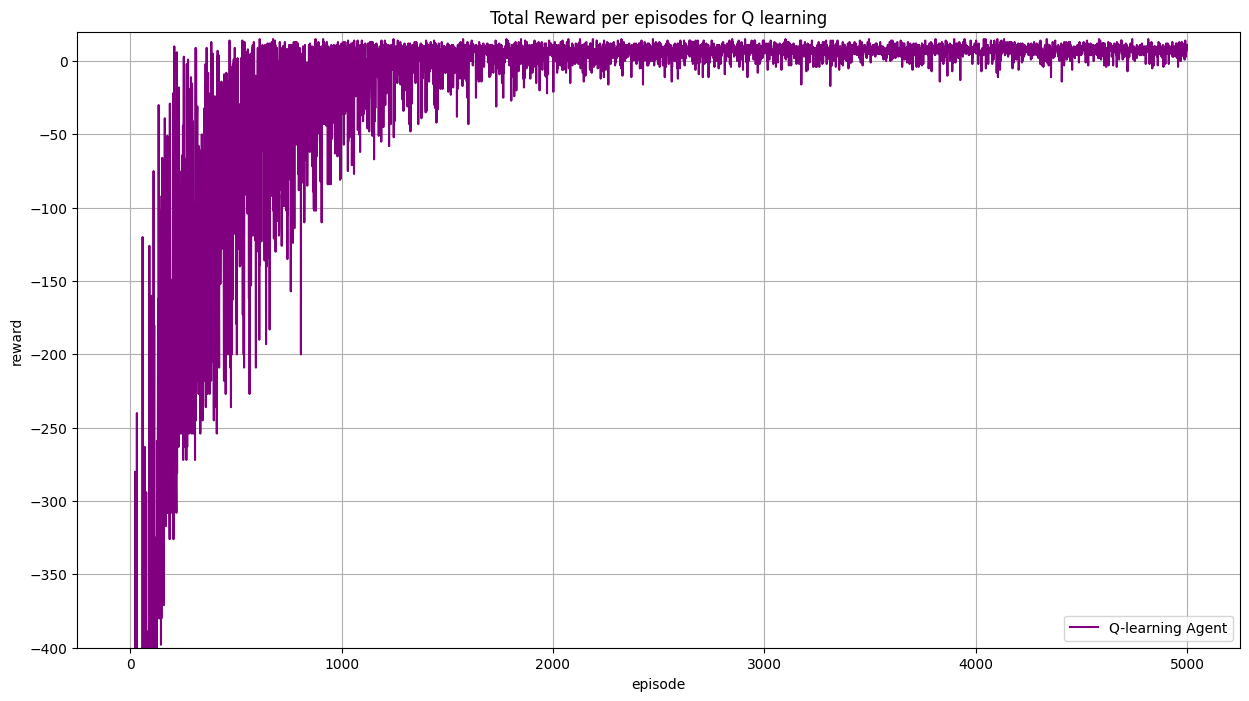

Number of times passenger was dropped off: 4776.0
Max reward: 15.0
Min reward: -902.0
Avg reward: -23.635
...... running with alpha = 0.1 and gamma = 0.7 ......
Training....
Learning done!


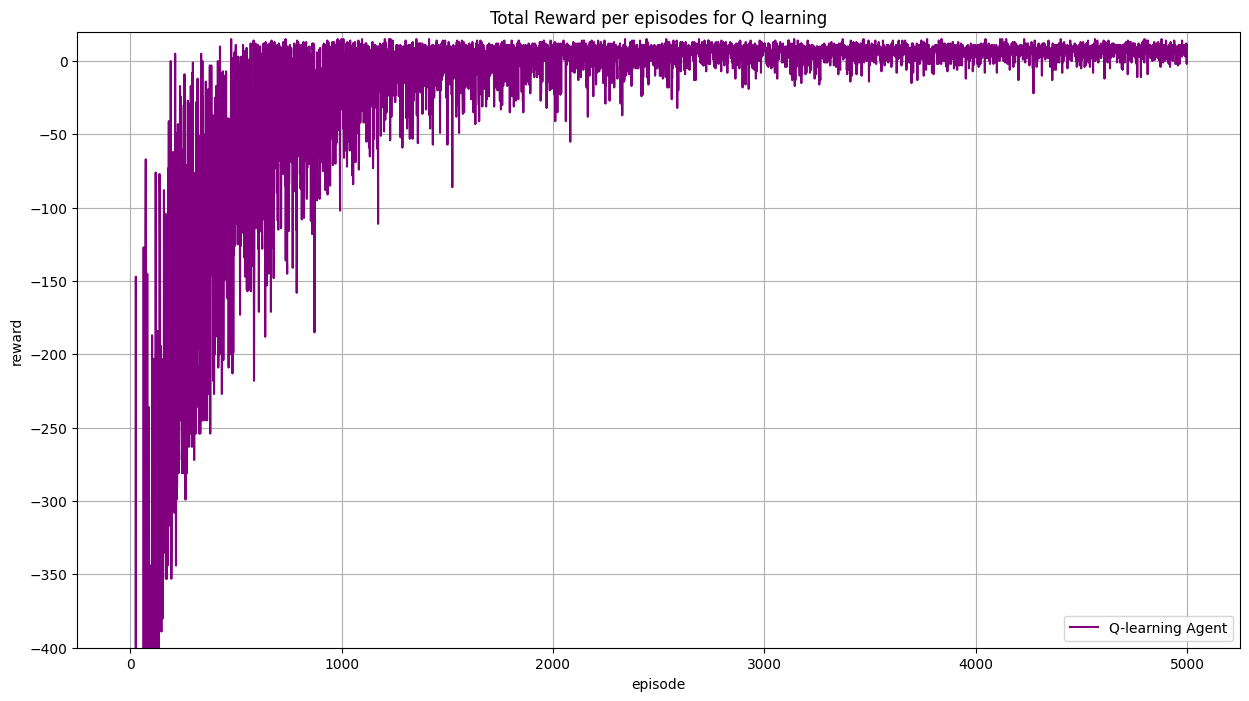

Number of times passenger was dropped off: 4770.0
Max reward: 15.0
Min reward: -866.0
Avg reward: -27.0968
alpha = 0.2
...... running with alpha = 0.2 and gamma = 1 ......
Training....
Learning done!


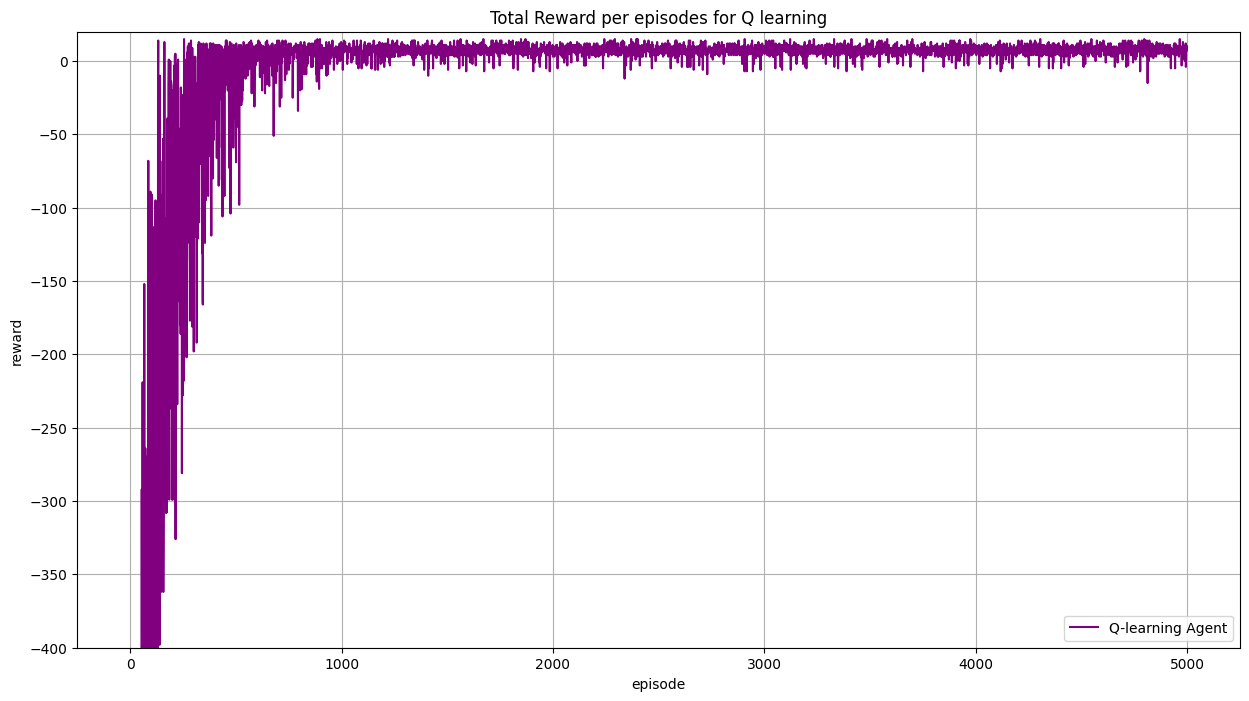

Number of times passenger was dropped off: 4879.0
Max reward: 15.0
Min reward: -902.0
Avg reward: -12.3274
...... running with alpha = 0.2 and gamma = 0.9 ......
Training....
Learning done!


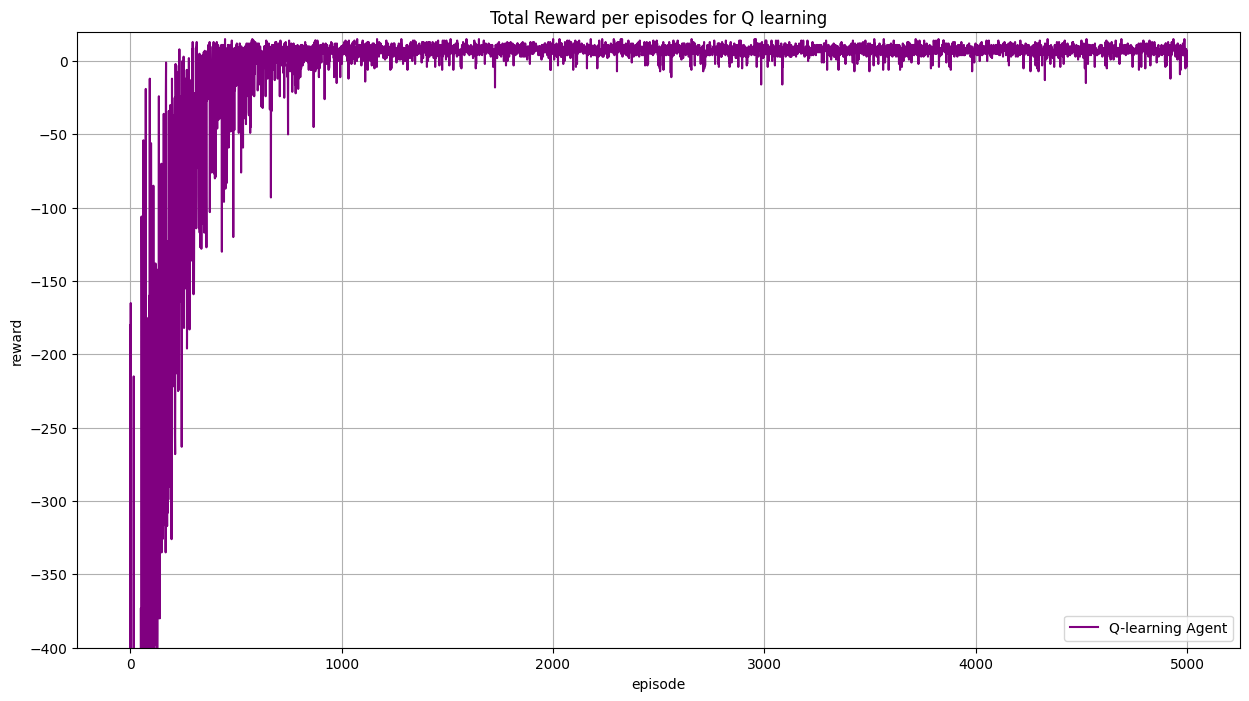

Number of times passenger was dropped off: 4883.0
Max reward: 15.0
Min reward: -938.0
Avg reward: -12.1378
...... running with alpha = 0.2 and gamma = 0.8 ......
Training....
Learning done!


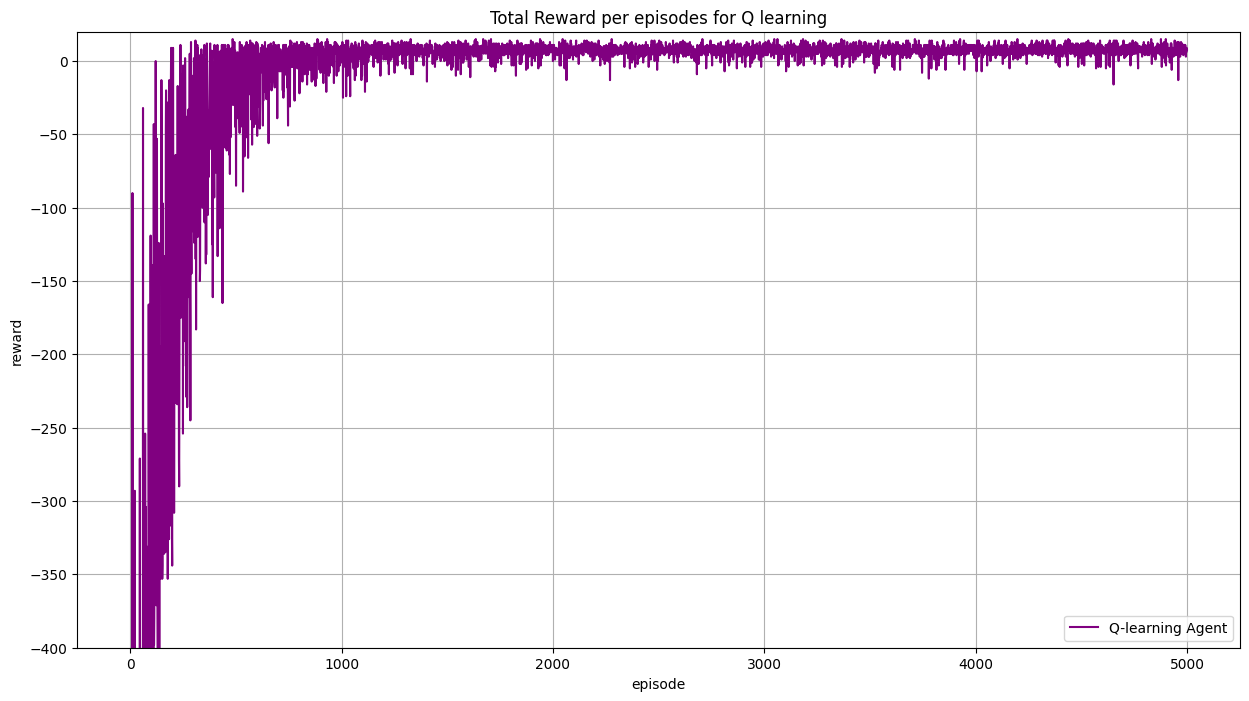

Number of times passenger was dropped off: 4873.0
Max reward: 15.0
Min reward: -839.0
Avg reward: -13.9124
...... running with alpha = 0.2 and gamma = 0.7 ......
Training....
Learning done!


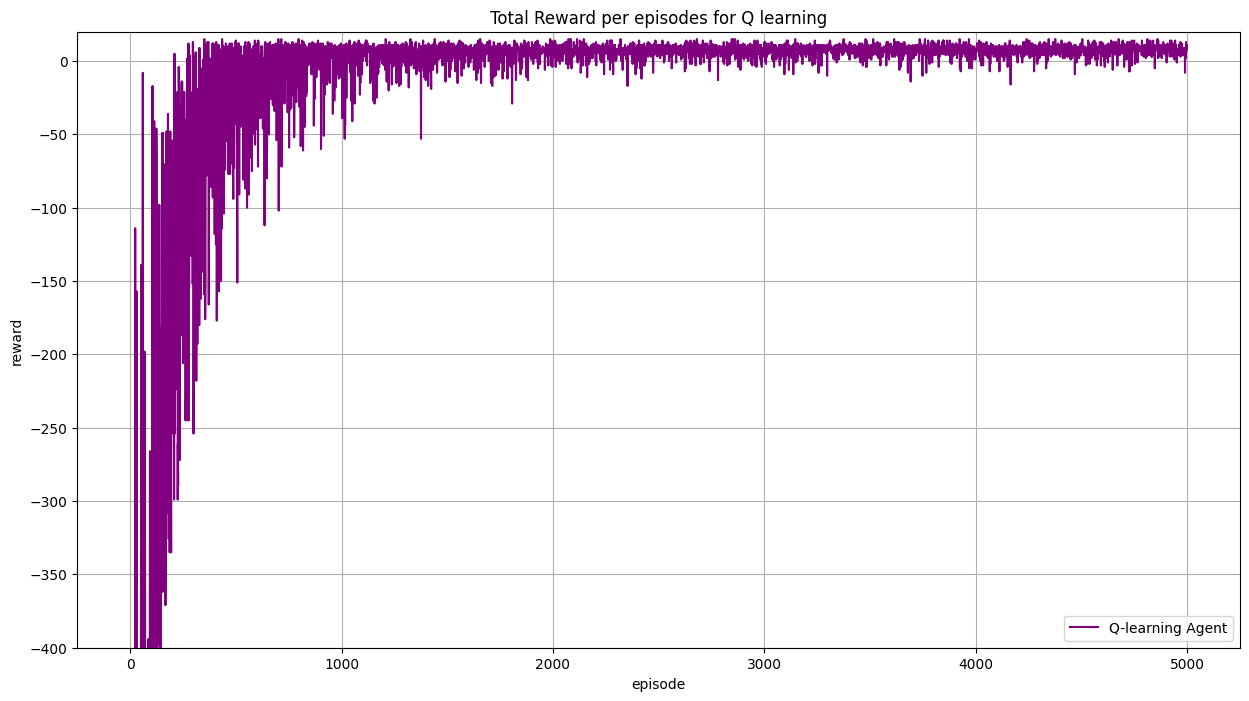

Number of times passenger was dropped off: 4862.0
Max reward: 15.0
Min reward: -848.0
Avg reward: -15.6214
alpha = 0.3
...... running with alpha = 0.3 and gamma = 1 ......
Training....
Learning done!


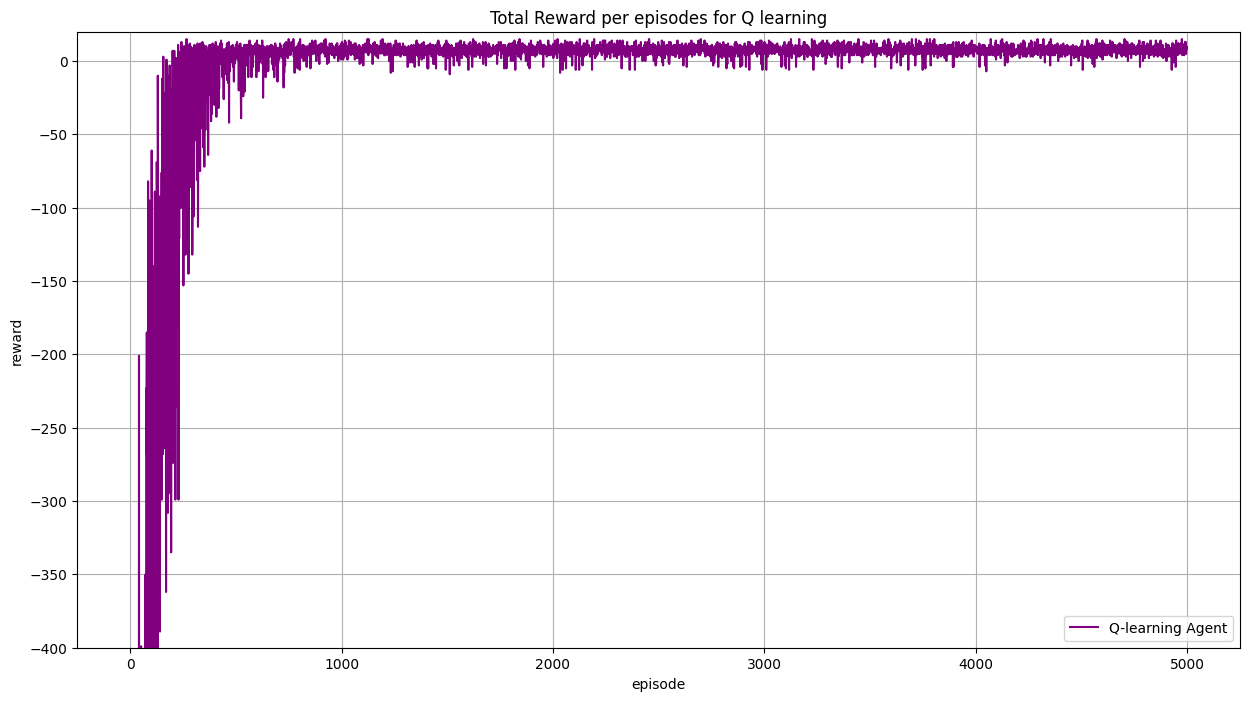

Number of times passenger was dropped off: 4893.0
Max reward: 15.0
Min reward: -839.0
Avg reward: -9.5274
...... running with alpha = 0.3 and gamma = 0.9 ......
Training....
Learning done!


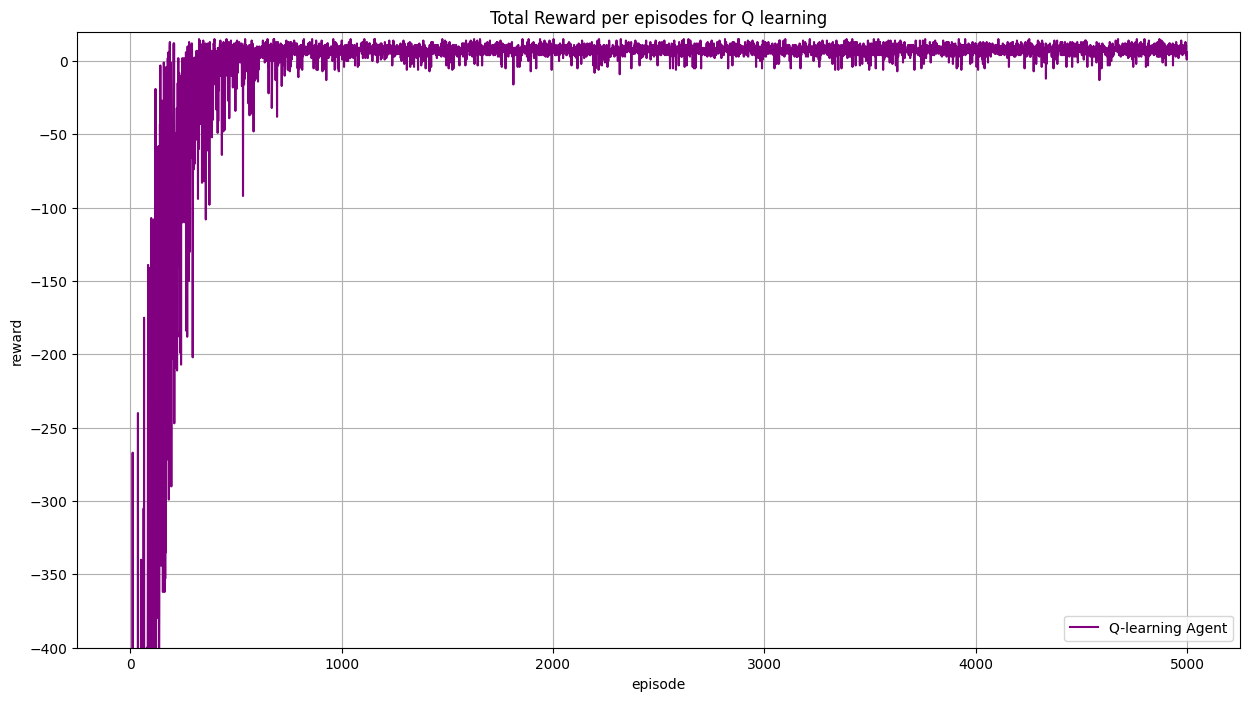

Number of times passenger was dropped off: 4893.0
Max reward: 15.0
Min reward: -947.0
Avg reward: -10.1456
...... running with alpha = 0.3 and gamma = 0.8 ......
Training....
Learning done!


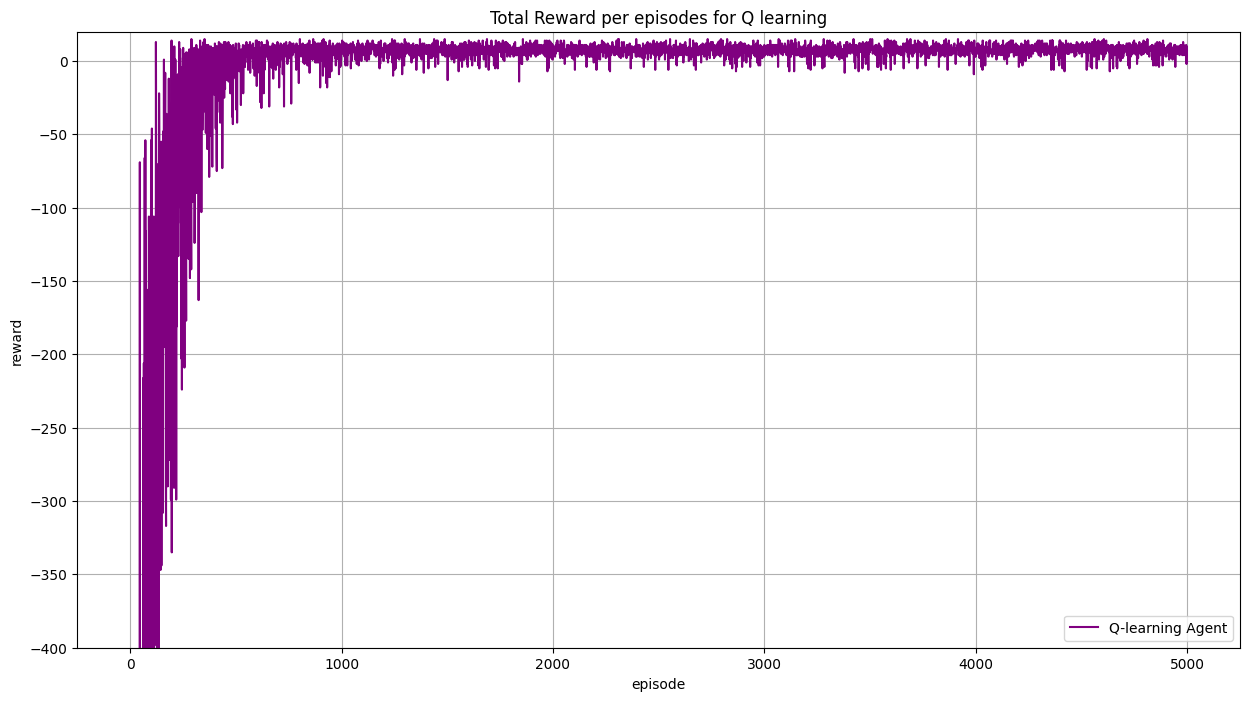

Number of times passenger was dropped off: 4903.0
Max reward: 15.0
Min reward: -875.0
Avg reward: -9.902
...... running with alpha = 0.3 and gamma = 0.7 ......
Training....
Learning done!


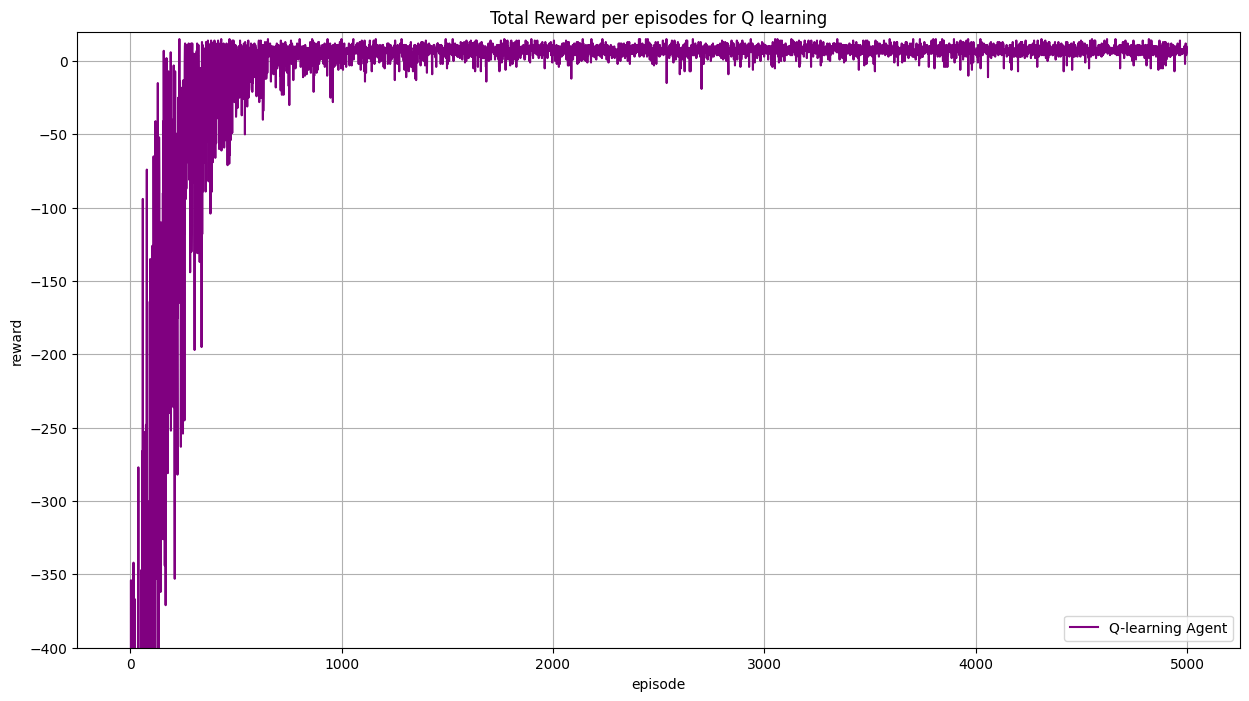

Number of times passenger was dropped off: 4888.0
Max reward: 15.0
Min reward: -875.0
Avg reward: -11.336


In [16]:
alpha = 0.1
gamma = 0.8

Q_rewards = pd.DataFrame()
Qperformance = {"alpha":[],"gamma":[],"avg_reward":[]}


for i in [0.1,0.2,0.3]:
    print(f"alpha = {i}")
    for j in [1,0.9,0.8,0.7]:
        print(f"...... running with alpha = {i} and gamma = {j} ......")
        alpha = i
        gamma = j
        Q_agent = Q_Agent(max_episodes, 
                max_steps, 
                test_episodes, 
                alpha = i, 
                gamma = j, 
                epsilon = 1.0, 
                decay_rate = 0.01,
                optimistic = False)
        name = "a"+str(i)+"_g"+str(j)
        Q_agent.run()
        Q_rewards[name] = pd.Series(Q_agent.reward_arr)

        
        Q_agent.export_csv(f"QAgent_a{i}_g{j}")
        Qperformance["alpha"].append(i)
        Qperformance["gamma"].append(j)
        Qperformance["avg_reward"].append((sum(Q_agent.reward_arr)/Q_agent.max_episodes))
Q_rewards.to_csv("Qlearning.csv")


In [17]:
Qperformance=pd.DataFrame.from_dict(Qperformance)

Qperformance.to_csv("Q_performance.csv",index = False)

In [18]:
Qperformance

alpha  gamma  avg_reward
0     0.1    1.0    -20.3486
1     0.1    0.9    -21.8100
2     0.1    0.8    -23.6350
3     0.1    0.7    -27.0968
4     0.2    1.0    -12.3274
5     0.2    0.9    -12.1378
6     0.2    0.8    -13.9124
7     0.2    0.7    -15.6214
8     0.3    1.0     -9.5274
9     0.3    0.9    -10.1456
10    0.3    0.8     -9.9020
11    0.3    0.7    -11.3360

alpha = 0.1
...... running with alpha = 0.1 and gamma = 1 ......
Training....
Learning done!


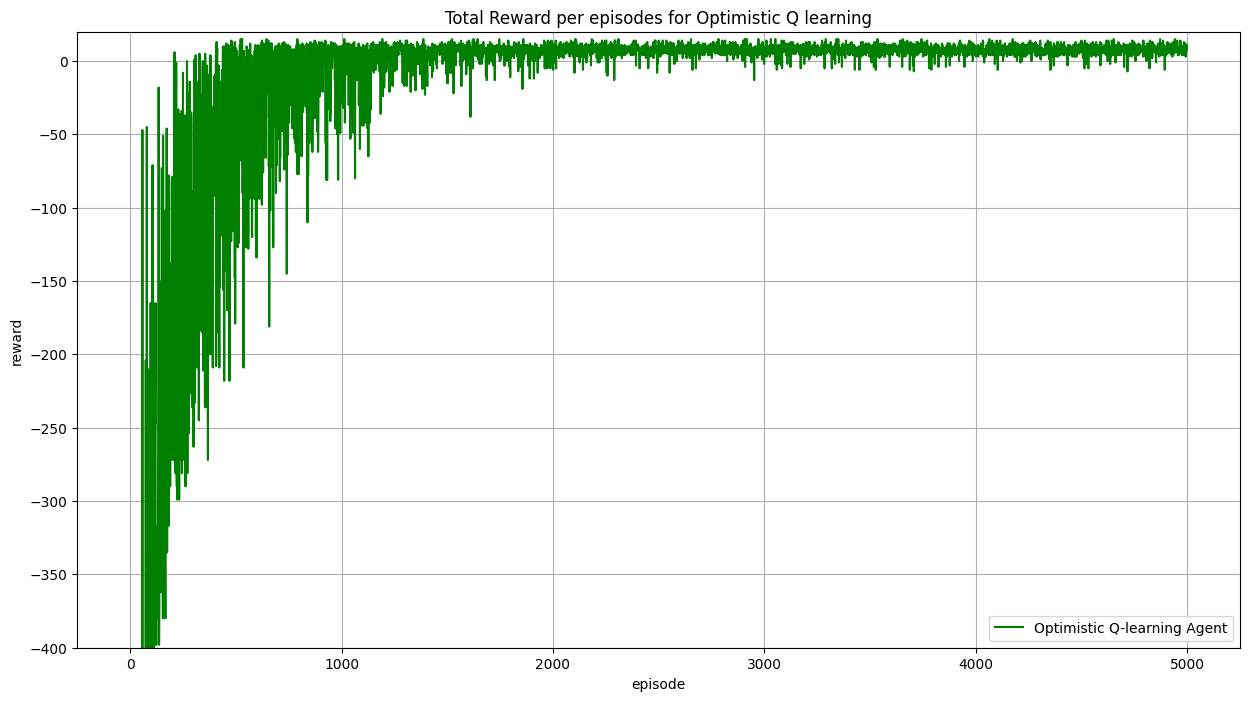

Number of times passenger was dropped off: 4799.0
Max reward: 15.0
Min reward: -839.0
Avg reward: -20.3612
...... running with alpha = 0.1 and gamma = 0.9 ......
Training....
Learning done!


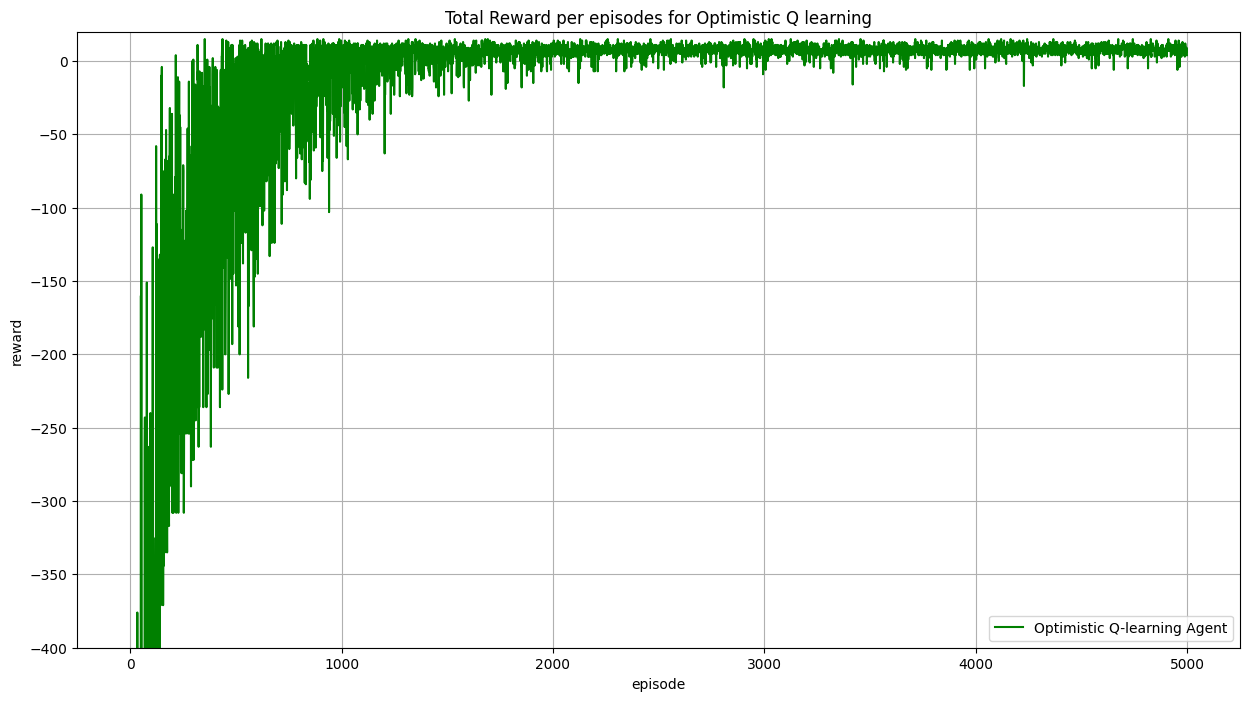

Number of times passenger was dropped off: 4789.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -21.6164
...... running with alpha = 0.1 and gamma = 0.8 ......
Training....
Learning done!


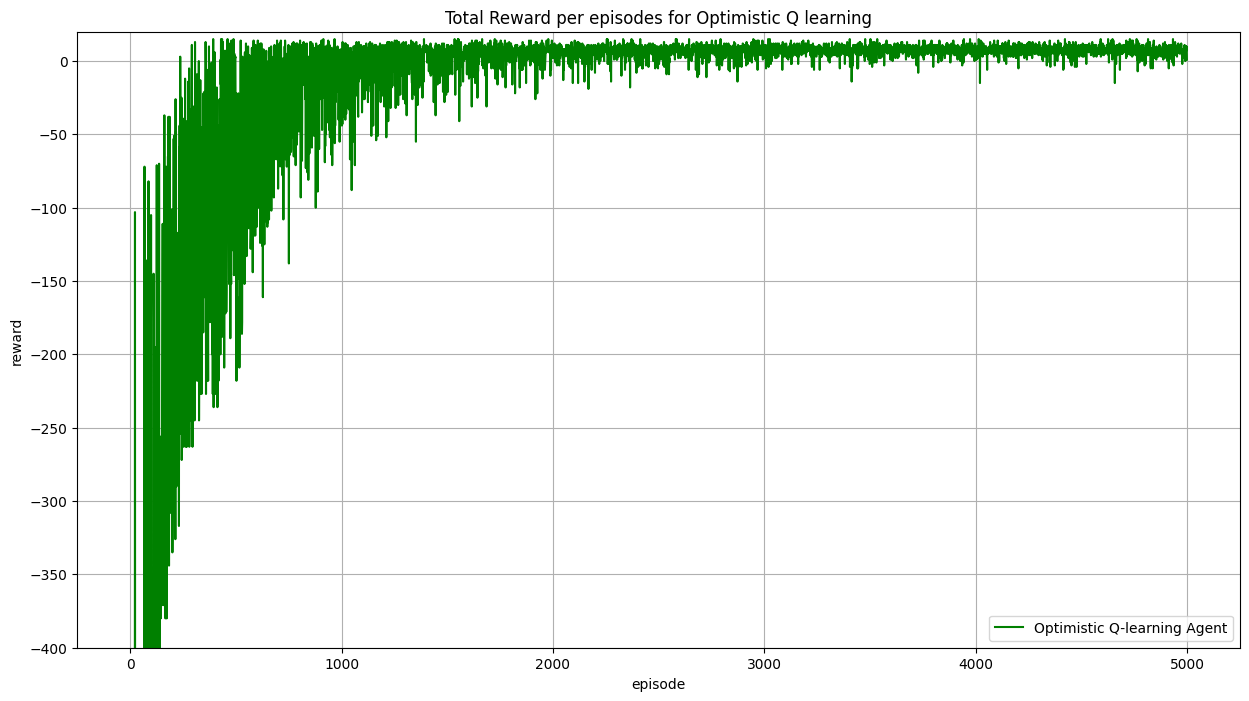

Number of times passenger was dropped off: 4788.0
Max reward: 15.0
Min reward: -884.0
Avg reward: -22.9642
...... running with alpha = 0.1 and gamma = 0.7 ......
Training....
Learning done!


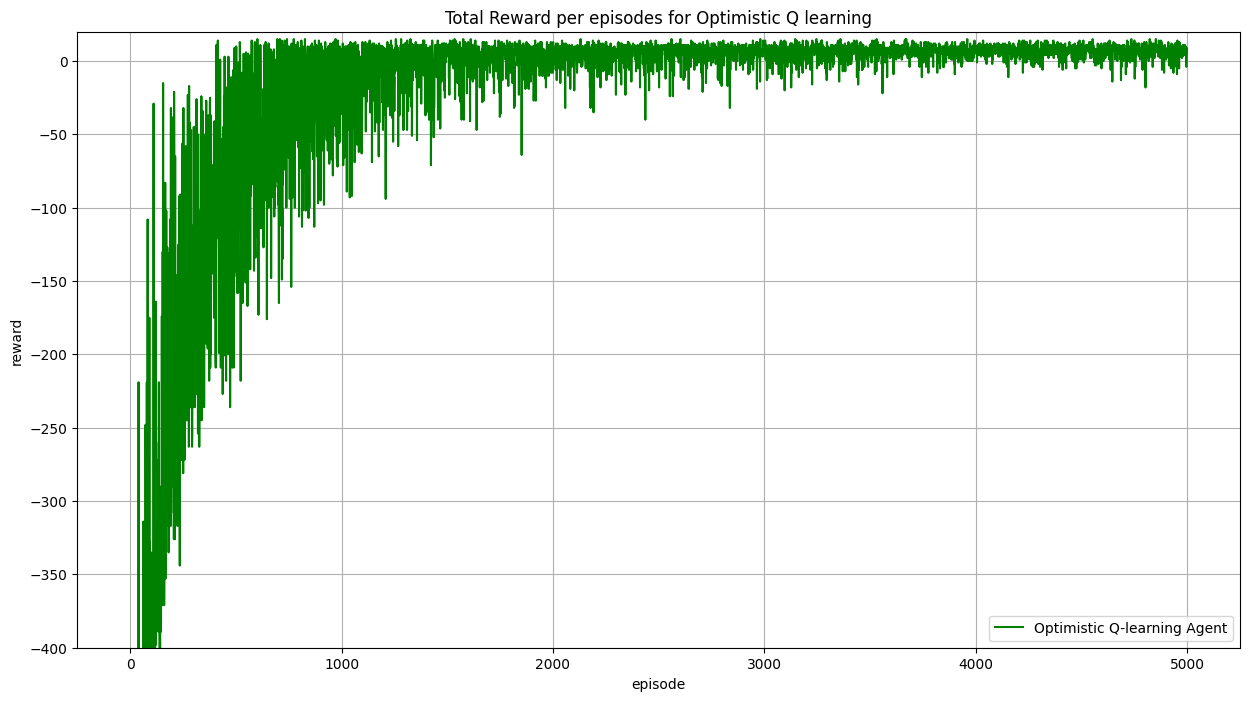

Number of times passenger was dropped off: 4772.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -25.7452
alpha = 0.2
...... running with alpha = 0.2 and gamma = 1 ......
Training....
Learning done!


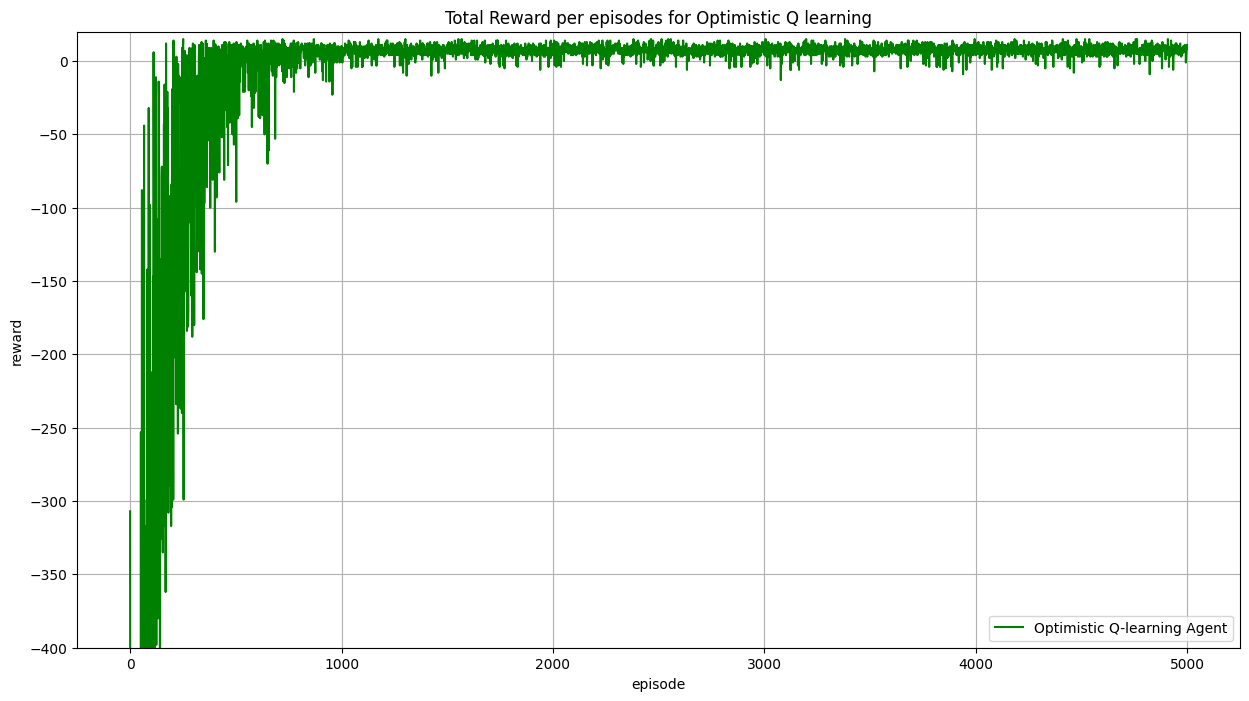

Number of times passenger was dropped off: 4885.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -11.9104
...... running with alpha = 0.2 and gamma = 0.9 ......
Training....
Learning done!


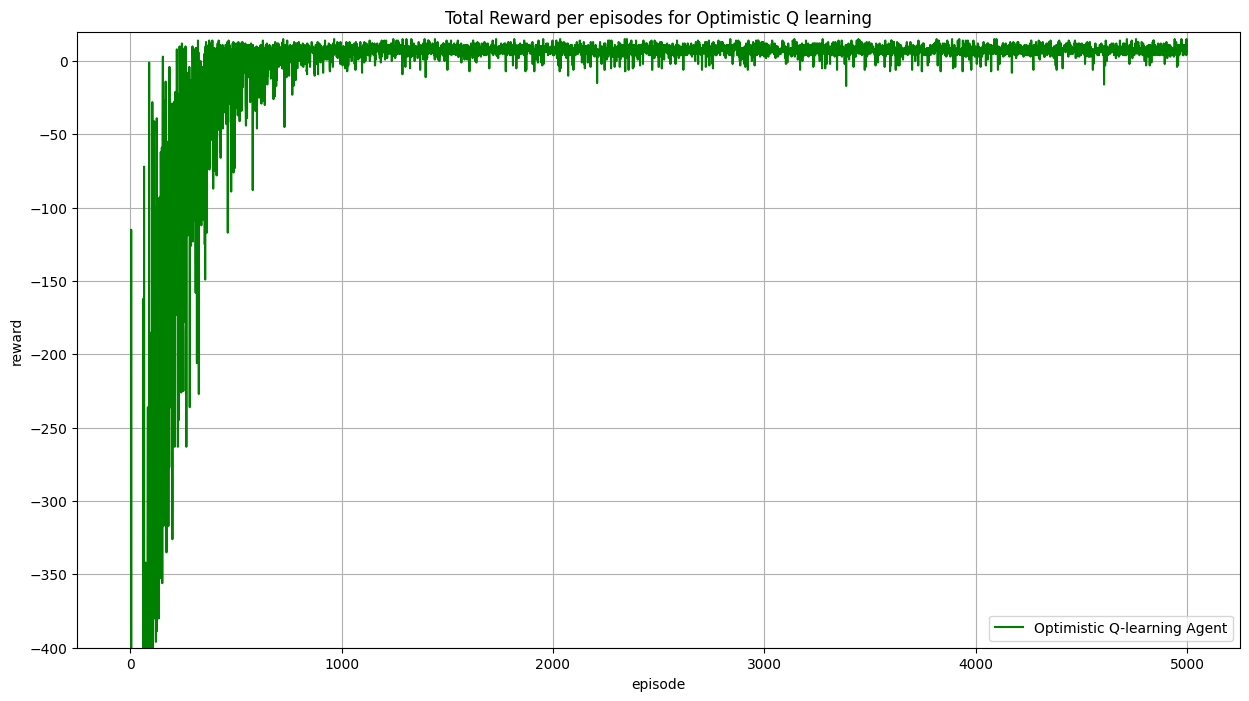

Number of times passenger was dropped off: 4879.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -12.3934
...... running with alpha = 0.2 and gamma = 0.8 ......
Training....
Learning done!


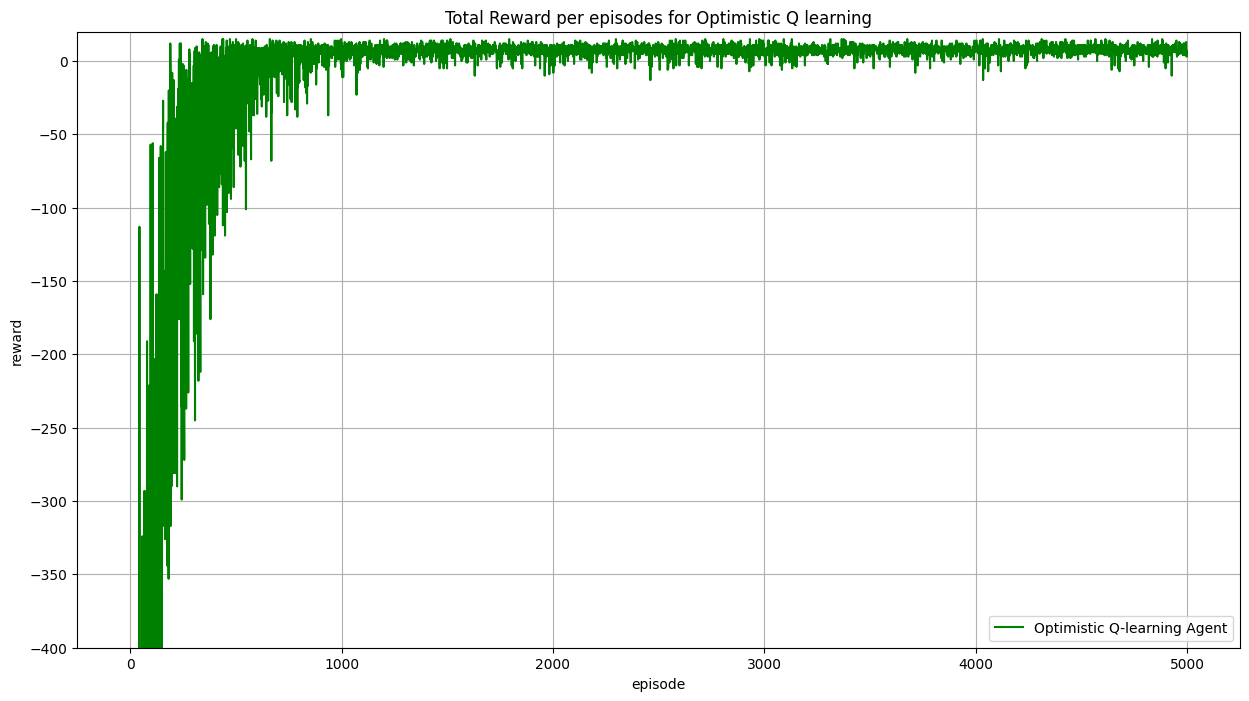

Number of times passenger was dropped off: 4857.0
Max reward: 15.0
Min reward: -884.0
Avg reward: -14.161
...... running with alpha = 0.2 and gamma = 0.7 ......
Training....
Learning done!


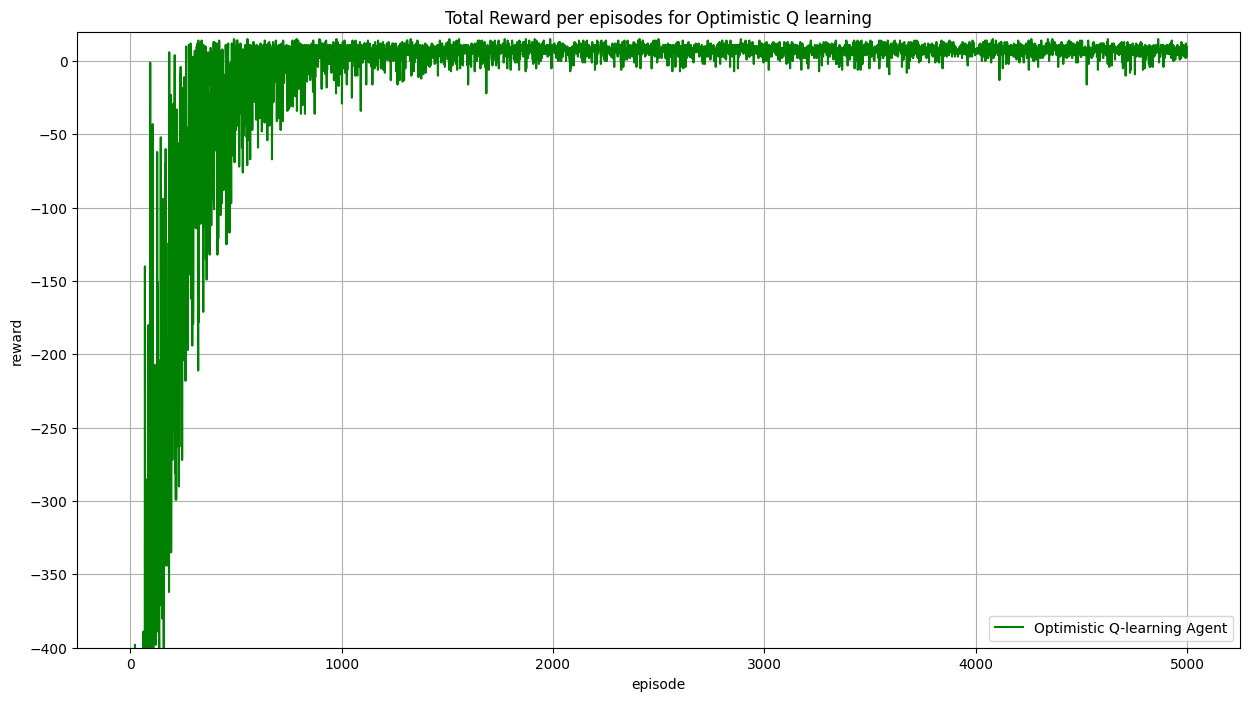

Number of times passenger was dropped off: 4863.0
Max reward: 15.0
Min reward: -920.0
Avg reward: -15.3684
alpha = 0.3
...... running with alpha = 0.3 and gamma = 1 ......
Training....
Learning done!


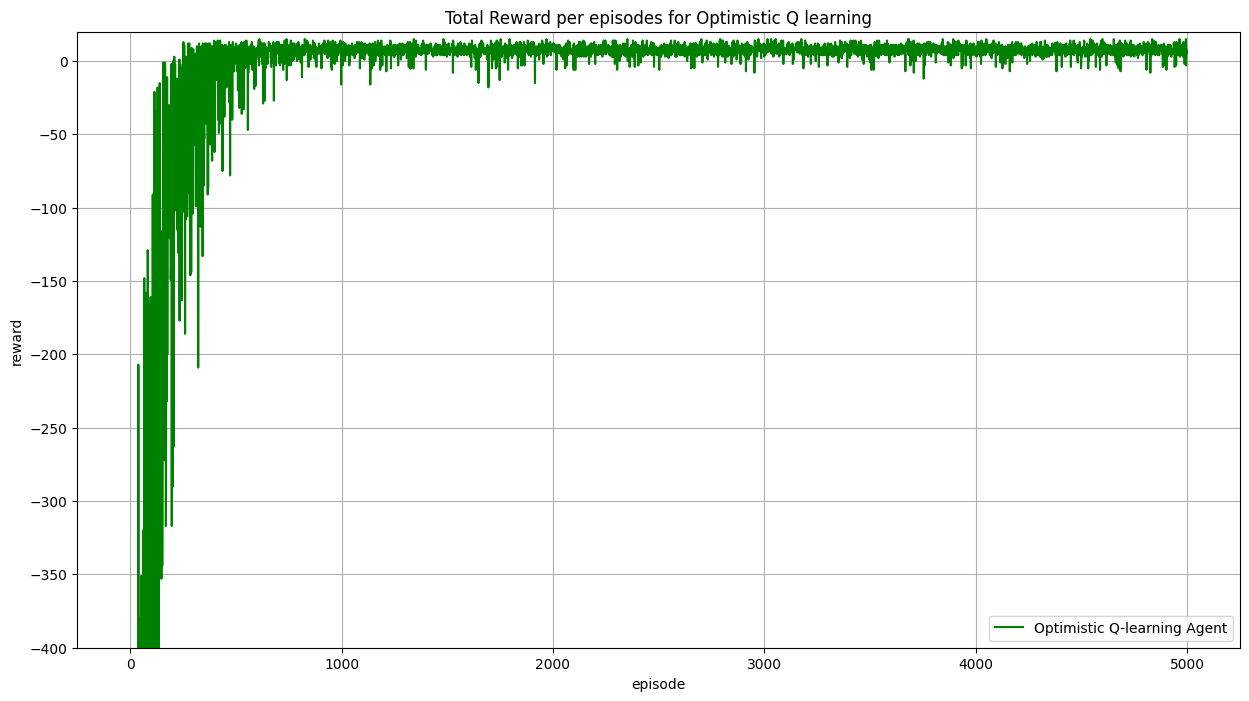

Number of times passenger was dropped off: 4891.0
Max reward: 15.0
Min reward: -866.0
Avg reward: -9.8504
...... running with alpha = 0.3 and gamma = 0.9 ......
Training....
Learning done!


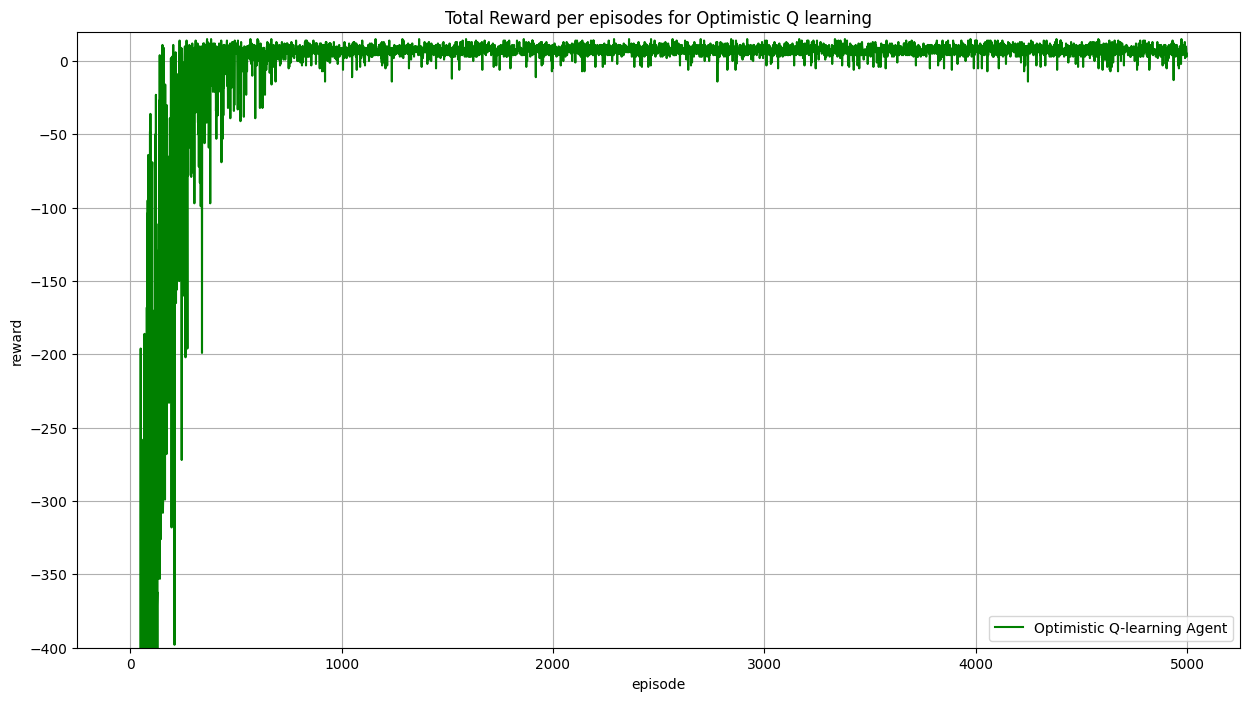

Number of times passenger was dropped off: 4898.0
Max reward: 15.0
Min reward: -866.0
Avg reward: -9.765
...... running with alpha = 0.3 and gamma = 0.8 ......
Training....
Learning done!


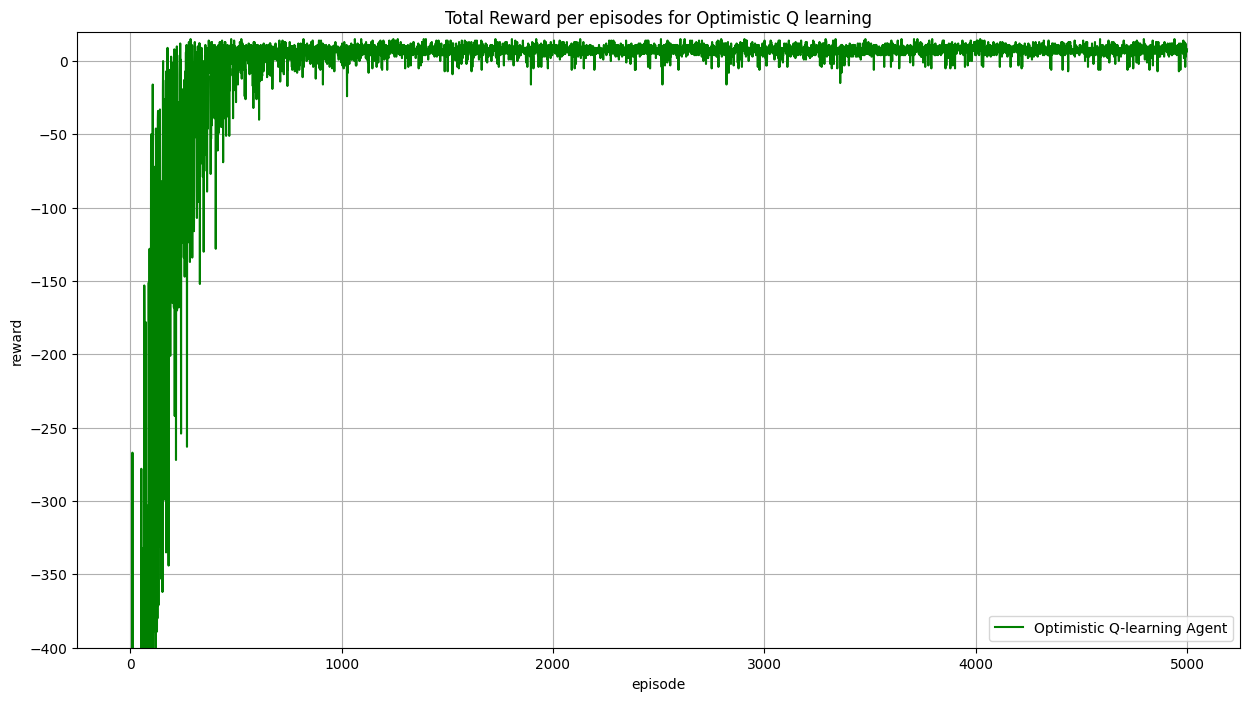

Number of times passenger was dropped off: 4893.0
Max reward: 15.0
Min reward: -902.0
Avg reward: -10.2442
...... running with alpha = 0.3 and gamma = 0.7 ......
Training....
Learning done!


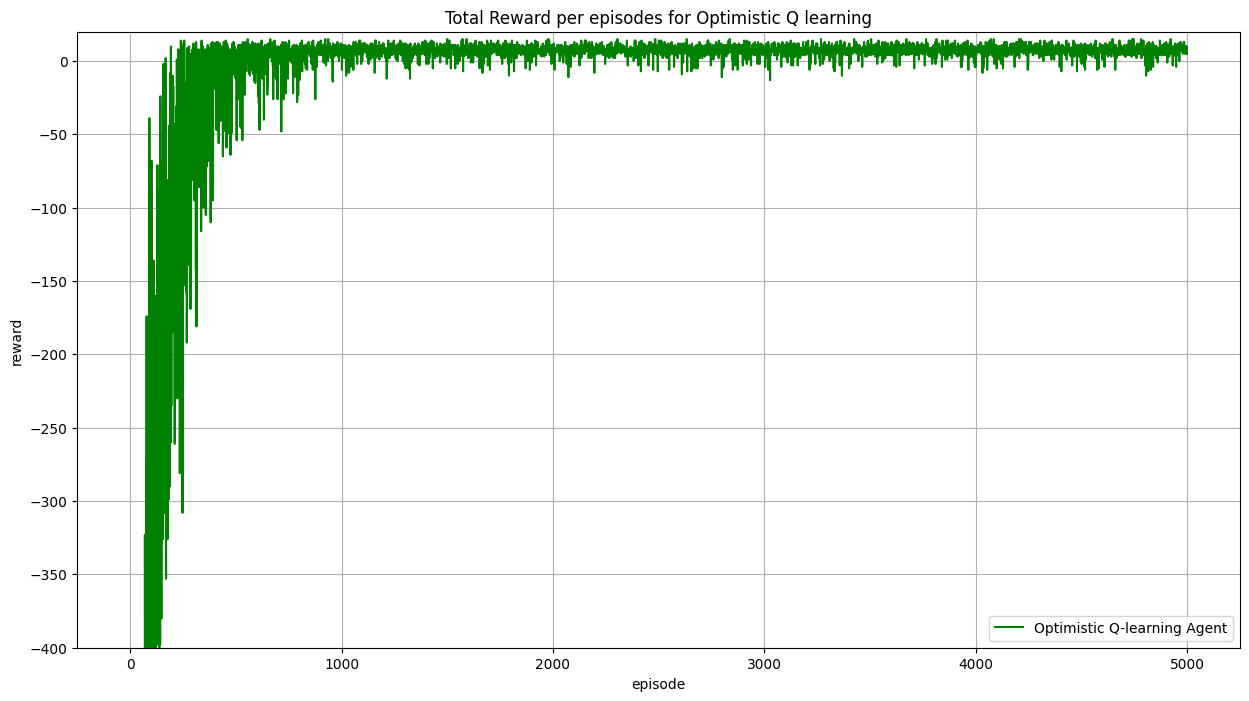

Number of times passenger was dropped off: 4877.0
Max reward: 15.0
Min reward: -857.0
Avg reward: -11.8306


a0.1_g1  a0.1_g0.9  a0.1_g0.8  a0.1_g0.7  a0.2_g1  a0.2_g0.9  a0.2_g0.8  \
0      -668.0     -495.0     -758.0     -776.0   -307.0     -695.0     -731.0   
1      -803.0     -767.0     -749.0     -848.0   -776.0     -785.0     -803.0   
2      -803.0     -722.0     -731.0     -839.0   -758.0     -812.0     -564.0   
3      -731.0     -857.0     -794.0     -857.0   -686.0     -509.0     -749.0   
4      -686.0     -857.0     -722.0     -767.0   -740.0     -767.0     -839.0   
...       ...        ...        ...        ...      ...        ...        ...   
4995      6.0        8.0       10.0        6.0      4.0        5.0       13.0   
4996      9.0        6.0        7.0       -4.0      5.0        4.0        6.0   
4997     11.0        9.0       10.0        2.0      9.0       15.0        5.0   
4998      8.0        9.0        7.0        9.0      8.0        5.0        3.0   
4999     10.0        4.0        1.0        6.0     11.0        8.0        7.0   

      a0.2_g0.7  a0.3_g1  a0.3_g0.9  a0.3_g0.8  a0.3_g0.7  
0        -920.0   -830.0     -830.0     -785.0     -758.0  
1        -812.0   -812.0     -866.0     -902.0     -740.0  
2        -776.0   -695.0     -785.0     -722.0     -785.0  
3        -848.0   -821.0     -830.0     -767.0     -767.0  
4        -758.0   -731.0     -686.0     -740.0     -803.0  
...         ...      ...        ...        ...        ...  
4995        7.0     -3.0        9.0        8.0        9.0  
4996        8.0      8.0        6.0        7.0        8.0  
4997       10.0      5.0        3.0        6.0        5.0  
4998       10.0      7.0        3.0        7.0       10.0  
4999        3.0      7.0        5.0        8.0        5.0  

[5000 rows x 12 columns]

In [19]:
alpha = 0.1
gamma = 0.8

OIV_Q_rewards = pd.DataFrame()
Qperformance = {"alpha":[],"gamma":[],"avg_reward":[]}


for i in [0.1,0.2,0.3]:
    print(f"alpha = {i}")
    for j in [1,0.9,0.8,0.7]:
        print(f"...... running with alpha = {i} and gamma = {j} ......")
        alpha = i
        gamma = j
        Q_agent = Q_Agent(max_episodes, 
                max_steps, 
                test_episodes, 
                alpha = i, 
                gamma = j, 
                epsilon = 1.0, 
                decay_rate = 0.01,
                optimistic = True)
        name = "a"+str(i)+"_g"+str(j)
        Q_agent.run()
        OIV_Q_rewards[name] = pd.Series(Q_agent.reward_arr)

        
        Q_agent.export_csv(f"QAgent_a{i}_g{j}")
        Qperformance["alpha"].append(i)
        Qperformance["gamma"].append(j)
        Qperformance["avg_reward"].append((sum(Q_agent.reward_arr)/Q_agent.max_episodes))
OIV_Q_rewards.to_csv("Optimistic_Qlearning.csv")
OIV_Q_rewards

best algo with alpha = 0.3 and gamma = 1

In [20]:
OIV_Q_rewards= OIV_Q_rewards["a0.3_g1"]
OIV_SARSA_rewards = OIV_SARSA_rewards["a0.3_g1"]
Q_rewards = Q_rewards["a0.3_g1"]
SARSA_rewards = SARSA_rewards["a0.3_g1"]

In [21]:
OIV_Q_rewards

0      -830.0
1      -812.0
2      -695.0
3      -821.0
4      -731.0
        ...  
4995     -3.0
4996      8.0
4997      5.0
4998      7.0
4999      7.0
Name: a0.3_g1, Length: 5000, dtype: float64

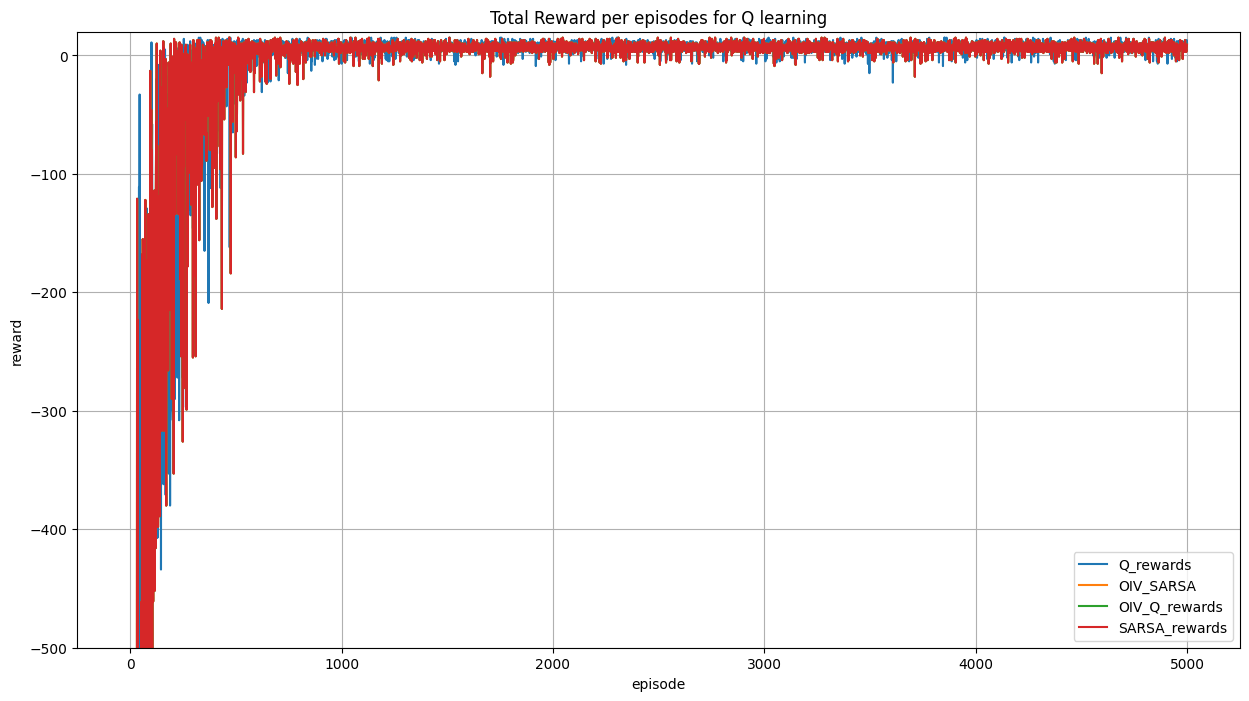

In [26]:
plt.figure(figsize=(15,8))
plt.title(f"Total Reward per episodes for Q learning")
plt.xlabel("episode")
plt.ylabel("reward")
plt.ylim(-500, 20)
plt.grid()
plt.plot(SARSA_rewards, label = "Q_rewards")
plt.plot(OIV_SARSA_rewards, label = "OIV_SARSA")
plt.plot(OIV_SARSA_rewards, label = "OIV_Q_rewards")
plt.plot(OIV_SARSA_rewards, label = "SARSA_rewards")


plt.legend()
plt.show()
